# **HW 3: Data Clustering**
<hr>

<u>**Members**</u><br>
Tharnarch Thoranisttakul 63340500025<br>
Athimet Aiewcharoen 63340500068
<hr>

In [2]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import plotly.express as px
from plotly.graph_objs import *
%matplotlib inline

import pandas_profiling as pp
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer, InterclusterDistance

# Preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

# Fetures selection
from sklearn.feature_selection import SelectKBest, f_classif, chi2,VarianceThreshold
from sklearn.decomposition import PCA

# Models
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, SpectralClustering, AffinityPropagation, Birch, MeanShift, OPTICS
from kmodes.kprototypes import KPrototypes
from sklearn.neighbors import NearestNeighbors

# Model selection
from sklearn.model_selection import train_test_split, GridSearchCV, RepeatedKFold, StratifiedKFold, cross_val_score

# Resampling
from imblearn.over_sampling import SMOTE, ADASYN, RandomOverSampler
from imblearn.under_sampling import InstanceHardnessThreshold, RandomUnderSampler, NearMiss

# Classification metrics
from sklearn.metrics import classification_report, confusion_matrix , silhouette_score , rand_score , adjusted_mutual_info_score, mutual_info_score

# Pipeline
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin

# For Hierarchical clustering
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

# Make image directory (img)
import os
currDir = os.getcwd()
if not os.path.exists('img'):
    os.mkdir('img')
if not os.path.exists('img/dataexplo'):
    os.mkdir('img/dataexplo')
if not os.path.exists('img/kmeans'):
    os.makedirs('img/kmeans')
if not os.path.exists('img/kprototype'):
    os.makedirs('img/kprototype')
if not os.path.exists('img/fcluster'):
    os.makedirs('img/fcluster')
if not os.path.exists('img/agglo'):
    os.makedirs('img/agglo')
if not os.path.exists('img/dbscan'):
    os.makedirs('img/dbscan')

# Set global random seed
np.random.seed(1)

In [3]:
from matplotlib.colors import ListedColormap
from matplotlib.cm import get_cmap

cmap = ListedColormap([(0.235, 0.635, 0.827), (0.863, 0.863, 0.863)])
pieCmap = get_cmap('plasma')
snsPalette = [(0.235, 0.635, 0.827), (0.475, 0.027, 0.082)]
bgColor = (0.059, 0.067, 0.102)
axBGColor = (0.863, 0.863, 0.863)
barColor = (0.235, 0.635, 0.827)
axTextColor = (0.9, 0.9, 0.9)
textColor = (0, 0, 0)
titleColor = (0.9, 0.9, 0.9)
plt.rcParams['figure.facecolor'] = bgColor
plt.rcParams['axes.facecolor'] = axBGColor
plt.rcParams['axes.edgecolor'] = axTextColor
plt.rcParams['axes.labelcolor'] = axTextColor
plt.rcParams['xtick.color'] = axTextColor
plt.rcParams['ytick.color'] = axTextColor
plt.rcParams['text.color'] = textColor
plt.rcParams['axes.titlecolor'] = titleColor
plt.rcParams['legend.labelcolor'] = titleColor

plotlyGridcolor = 'rgba(0.9, 0.9, 0.9, 0.3)'

In [ ]:
# test plotly graph
testDf = pd.DataFrame({'x': [2, 3, 4, 5], 'y': [4, 9, 16, 25]})
fig = px.scatter(testDf, x='x', y='y', title='Test Plotly Graph', color='y')
fig.update_layout(paper_bgcolor=f'rgb{str(bgColor)}',
                  plot_bgcolor=f'rgb{str(bgColor)}',
                  font_color=f'rgb{str(titleColor)}',
                  xaxis_color=f'rgb{str(axTextColor)}',
                  yaxis_color=f'rgb{str(axTextColor)}',
                  xaxis_gridcolor=plotlyGridcolor,
                  yaxis_gridcolor=plotlyGridcolor)
fig.update_xaxes(showline=True, linewidth=2, linecolor='white')
fig.update_yaxes(showline=True, linewidth=2, linecolor='white')
fig.show()


## **Data Exploration**

From the description file, there are a total of 17 features in this dataset which are:

|Feature Name|Description|Data Type|
|:-:|-|:-:|
|<font color='green'>age</font>|Customer's age (in years)|<font color='red'>Numerical</font>|
|<font color='green'>job</font>|Types of Job|<font color='red'>Categorical</font>|
|<font color='green'>marital</font>|Marital Status|<font color='red'>Categorical</font>|
|<font color='green'>education</font>|Education|<font color='red'>Categorical</font>|
|<font color='green'>default</font>|Has credit in Default?|<font color='red'>Categorical</font>|
|<font color='green'>balance</font>|Average yearly balance|<font color='red'>Numerical</font>|
|<font color='green'>housing</font>|Has housing loan?|<font color='red'>Categorical</font>|
|<font color='green'>loan</font>|Has personal loan?|<font color='red'>Categorical</font>|
|<font color='green'>contact</font>|Contact Communication Type|<font color='red'>Categorical</font>|
|<font color='green'>day</font>|Last contact day of the month|<font color='red'>Numerical</font>|
|<font color='green'>month</font>|Last contact month of the year|<font color='red'>Categorical</font>|
|<font color='green'>duration</font>|Last contact duration (in seconds).<br><br> Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.|<font color='red'>Numerical</font>|
|<font color='green'>campaign</font>|no. of contacts performed during this campaign and for this client|<font color='red'>Numerical</font>|
|<font color='green'>pdays</font>|no. of days that passed by after the client was last contacted from a previous campaign (-1 means client was not previously contacted)|<font color='red'>Numerical</font>|
|<font color='green'>previous</font>|no. of contacts performed before this campaign and for this client|<font color='red'>Numerical</font>|
|<font color='green'>poutcome</font>|outcome of the previous marketing campaign|<font color='red'>Categorical</font>|
|<font color='green'>y</font>|has the client subscribed a term deposit?|<font color='red'>Categorical</font> [Output]|

Number of instances: 45211 for bank-full.csv <br>
Number of Attributes: 16 + output attribute (17)<br>
(45211 rows, 17 columns)

Missing Attribute Values: None

### **Import Dataset**

In [ ]:
dfOri = pd.read_csv('../HWdata/bank/bank-full.csv', sep=';')
df = dfOri.copy()

In [ ]:
df.head()

In [ ]:
df.tail()

In [ ]:
print(f"No. of Instances: {df.shape[0]}\nNo. of Features: {df.shape[1]}")

### **Remove Unnecessary Features**

In [ ]:
if 'duration' in df.columns:
    df.drop('duration', axis=1, inplace=True)
    print(f"No. of Features Left: {df.shape[1]}")
else:
    print("\'Duration\' removed!")

### **Check and Remove Duplicates** 

In [ ]:
print(f"No. of Duplicates: {df.duplicated().sum()}")

In [ ]:
if df.duplicated().sum() > 0:
    df.drop_duplicates(inplace=True)
    print(f"No. of Instances Left: {df.shape[0]}")
else:
    print("No duplicates!")

In [ ]:
df.info()

### **Check and Remove Missing Values**

In [ ]:
if df.isna().sum().sum() > 0:
    df.dropna(inplace=True)
    print(f"No. of Instances Left: {df.shape[0]}")
else:
    print("No missing values!")

### **Replace Data in "pdays"**
The datasets stated that the value of -1 in "pdays" means that the client was not previously contacted. However, negative numbers are not valid for "pdays" because days can't be negative. Therefore, we will replace -1 with 0.

In [ ]:
df['pdays'].value_counts()

In [ ]:
df['pdays'].replace(-1, 0, inplace=True)
df['pdays'].value_counts()

To conclude everything up to this point, there were <u>1 unnecessary feature</u>, <u>16 duplicated instances</u> and <u>no missing values</u> that we have removed. This means that we are left with a total of **45195 instances and 16 features**.

In which, there are:

- 10 features, including output, that are '<font color='green'>object</font>', which means that they are '<font color='red'>Categorical Features</font>'.
- 6 features that are '<font color='green'>int64</font>', which means that they are '<font color='red'>Numerical Features</font>'

### **Sort Features**
**Order:**
1. Numerical Features
2. Categorical Features

**Separate Numerical Features from Dataset**

In [ ]:
dfNum = df.select_dtypes(include=['int64'])

**Separate Categorical Features from Dataset**

In [ ]:
dfCate = df.select_dtypes(include=['object'])

**Concatenate Separated Data**

In [ ]:
df = pd.concat([dfNum, dfCate], axis=1)

In [ ]:
df.info()

### **Overall Report**

In [ ]:
dfProfile = df.copy()
dfProfile.reset_index(drop=True, inplace=True)
profile = pp.ProfileReport(dfProfile, title="Bank Full Report", dark_mode=True)
profile.config.html.style.primary_color = '#3CA2D3'
if not os.path.exists(os.path.join(currDir, 'HW3OverallReport.html')):
    profile.to_file('HW3OverallReport.html')
profile.to_notebook_iframe()

#### **Plot Histograms and Value Count Charts**

In [ ]:
NumHists, axes = plt.subplots(2, 3, figsize=(20, 10))
for idx, col in enumerate(dfNum.columns):
    if idx in [1, 3, 4, 5]:
        bins = 15
    else:
        bins = 'auto'
    if col != 'y' and idx < 3:
        sns.histplot(ax = axes[0, idx],
                     data = df,
                     x = col,
                     kde = False,
                     bins = bins,
                     color = barColor)
        axes[0, idx].set_title(col + " (Base)")
    else:
        sns.histplot(ax = axes[1, idx-3],
                     data = df,
                     x = col,
                     kde = False,
                     bins = bins,
                     color = barColor)
        axes[1, idx-3].set_title(col + " (Base)")
NumHists.suptitle("Histograms of Numerical Features",
                  fontsize = 24,
                  color = titleColor)
NumHists.subplots_adjust(top=0.9)


In [ ]:
np.linspace(0, 1, num=len(df['education'].value_counts()))
df['education'].unique().tolist()

In [ ]:
df['education'].value_counts(normalize=True)

In [ ]:
CateDonut, axes = plt.subplots(4, 3, figsize=(40,40))
bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
kw = dict(arrowprops=dict(arrowstyle="-", color='w', lw=0.5),
          bbox=bbox_props, zorder=0, va="center")
for idx, col in enumerate(dfCate.columns):
    labelName = df[col].unique().tolist()
    if idx < 3:
        wedges, texts = axes[0, idx].pie(df[col].value_counts().sort_index() / df[col].value_counts().sum() * 100,
                                            startangle = 95,
                                            colors = pieCmap(np.linspace(0, 1, num=len(df[col].value_counts()))),
                                            wedgeprops=dict(width=0.4))
        axes[0, idx].set_title(col + " (Base)", pad=30)
        for i, p in enumerate(wedges):
            ang = (p.theta2 - p.theta1)/2. + p.theta1
            y = np.sin(np.deg2rad(ang))
            x = np.cos(np.deg2rad(ang))
            horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
            connectionstyle = "angle,angleA=0,angleB={}".format(ang)
            kw["arrowprops"].update({"connectionstyle": connectionstyle})
            axes[0, idx].annotate(f"{labelName[i]}\n{df[col].value_counts(normalize=True)[i]*100:.2f}%", xy=(x, y), xytext=(1.1*np.sign(x), 1.2*y),
                        horizontalalignment=horizontalalignment, **kw)
    elif idx < 6:
        wedges, texts = axes[1, idx-3].pie(df[col].value_counts().sort_index() / df[col].value_counts().sum() * 100,
                                            startangle = 60,
                                            colors = pieCmap(np.linspace(0, 1, num=len(df[col].value_counts()))),
                                            wedgeprops=dict(width=0.4))
        axes[1, idx-3].set_title(col + " (Base)", pad=30)
        for i, p in enumerate(wedges):
            ang = (p.theta2 - p.theta1)/2. + p.theta1
            y = np.sin(np.deg2rad(ang))
            x = np.cos(np.deg2rad(ang))
            horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
            connectionstyle = "angle,angleA=0,angleB={}".format(ang)
            kw["arrowprops"].update({"connectionstyle": connectionstyle})
            axes[1, idx-3].annotate(f"{labelName[i]}\n{df[col].value_counts(normalize=True)[i]*100:.2f}%", xy=(x, y), xytext=(1.1*np.sign(x), 1.2*y),
                        horizontalalignment=horizontalalignment, **kw)
    elif idx < 9:
        wedges, texts = axes[2, idx-6].pie(df[col].value_counts().sort_index() / df[col].value_counts().sum() * 100,
                                            startangle = 90,
                                            colors = pieCmap(np.linspace(0, 1, num=len(df[col].value_counts()))),
                                            wedgeprops=dict(width=0.4))
        axes[2, idx-6].set_title(col + " (Base)", pad=30)
        for i, p in enumerate(wedges):
            ang = (p.theta2 - p.theta1)/2. + p.theta1
            y = np.sin(np.deg2rad(ang))
            x = np.cos(np.deg2rad(ang))
            horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
            connectionstyle = "angle,angleA=0,angleB={}".format(ang)
            kw["arrowprops"].update({"connectionstyle": connectionstyle})
            axes[2, idx-6].annotate(f"{labelName[i]}\n{df[col].value_counts(normalize=True)[i]*100:.2f}%", xy=(x, y), xytext=(1.1*np.sign(x), 1.2*y),
                        horizontalalignment=horizontalalignment, **kw)
    else:
        wedges, texts = axes[3, 1].pie(df[col].value_counts().sort_index() / df[col].value_counts().sum() * 100,
                                            colors = pieCmap(np.linspace(0, 1, num=len(df[col].value_counts()))),
                                            wedgeprops=dict(width=0.4))
        axes[3, 1].set_title(col + " (Base)", pad=30)
        for i, p in enumerate(wedges):
            ang = (p.theta2 - p.theta1)/2. + p.theta1
            y = np.sin(np.deg2rad(ang))
            x = np.cos(np.deg2rad(ang))
            horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
            connectionstyle = "angle,angleA=0,angleB={}".format(ang)
            kw["arrowprops"].update({"connectionstyle": connectionstyle})
            axes[3, 1].annotate(f"{labelName[i]}\n{df[col].value_counts(normalize=True)[i]*100:.2f}%", xy=(x, y), xytext=(1.1*np.sign(x), 1.2*y),
                        horizontalalignment=horizontalalignment, **kw)
        axes[3, 0].axis('off')
        axes[3, 2].axis('off')
CateDonut.suptitle("Donut Plot", fontsize=48, color=titleColor)
CateDonut.subplots_adjust(top=0.95)

In [ ]:
df_vis = df.copy()
df_vis.columns
df_vis['month'] = pd.Categorical(df_vis['month'],['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec'])

In [ ]:
dayMonthPlot, axes = plt.subplots(1, 2, figsize=(20, 10))
sns.histplot(data = df_vis, 
            x = 'day', 
            hue = 'y',
            bins=31,
            ax=axes[0],
            palette = snsPalette)
sns.histplot(data = df_vis, 
            x = 'month', 
            hue = 'y',
            ax=axes[1],
            palette = snsPalette)
dayMonthPlot.suptitle("Day and Month Distribution", fontsize=24, color=titleColor, horizontalalignment='center')

In [ ]:
MoneyPlot, axes = plt.subplots(1, 3, figsize=(15, 5))
sns.histplot(data = df_vis, 
            x = 'default', 
            hue = 'y',
            palette = snsPalette,
            ax=axes[0])
sns.histplot(data = df_vis, 
            x = 'housing', 
            hue = 'y',
            palette = snsPalette,
            ax=axes[1])
sns.histplot(data = df_vis, 
            x = 'loan', 
            hue = 'y',
            palette = snsPalette,
            ax=axes[2])

### **Grouping Data for Visualization**

In [ ]:
age_group = pd.cut(df_vis['age'], [10, 20, 30, 40, 50, 60, 70, 80])
df_vis['age'] = age_group
sum_group = df_vis[['balance','age']].groupby('age').sum()
mean_group  = df_vis[['balance','age']].groupby('age').mean()

In [ ]:
ageGroupPlot, axes = plt.subplots(1, 2, figsize=(20, 8))
axes = axes.flatten()

sns.barplot(x=sum_group['balance'], y=sum_group.index, ci=None, orient='h', ax=axes[0])
axes[0].set_title('Total balance \nby Age Groups', weight='bold', fontsize=16)

for i,v in enumerate(sum_group['balance']):
    if i in [1, 2, 3, 4]:
        axes[0].text(v-1000000, i, '$ {}'.format(v), horizontalalignment='right', verticalalignment='center', weight='bold', color='black', fontsize=12)
    else:
        axes[0].text(v+500000, i, '$ {}'.format(v), horizontalalignment='left', verticalalignment='center', weight='bold', color='black', fontsize=12)

sns.barplot(x=mean_group['balance'], y=mean_group.index, ci=None, orient='h', ax=axes[1])
axes[1].set_title('Average balance \nby Age Groups', weight='bold', fontsize=16)

for i,v in enumerate(mean_group['balance']):
    axes[1].text(v-130, i, '$ {}'.format(round(v,2)), horizontalalignment='right', verticalalignment='center', weight='bold', color='black', fontsize=12)

### **Pairplotting Data Samples**

We will be pairplotting a tenth of the whole dataset to see the distribution of the data.

In [ ]:
# PairSamp, ax = plt.subplots(1, 1, figsize=(10, 10))
PairSamp = sns.pairplot(data = df.sample(int(df.shape[0]/10), random_state=777),
             diag_kind = 'kde',
             hue = 'y',
             palette = snsPalette[::-1])
PairSamp.fig.suptitle("Pairplot of Sampled Data",
                      fontsize=16,
                      color=titleColor)
PairSamp.fig.subplots_adjust(top=0.95)

From the pairplot, we can see that the variance between features are quite low and the variance within features are quite high.

In [ ]:
df.to_csv('bank_cleaned.csv', index=False)

In [ ]:
dfOri = pd.read_csv('bank_cleaned.csv')
dfNum = dfOri.select_dtypes(include=['int64'])
dfCate = dfOri.select_dtypes(include=['object'])
df = dfOri.copy()
df

### **Data Reconstruction**

In this section, we will be reconstructing the data by remapping unique values of each categorical features.

In [ ]:
df.head()

We will first print out all the unique values of each categorical features and look for unknowns and values that can be grouped together.

In [ ]:
dfCate = df.select_dtypes(include=['object'])
for col in dfCate.columns:
    print(f"{col}: {dfCate[col].unique()}\n")

From the above, we will be selecting the following features to check value counts in percentage:
- job
- marital
- education
- contact
- poutcome

In [ ]:
selectCol = ['job', 'marital', 'education', 'contact', 'poutcome']
for col in selectCol:
    print(f"{col}:\n{(df[col].value_counts(normalize=True)*100)}\n")

Now that we know the percentage of each value in each categorical features, we will be grouping the values as follow:
- job: group according to https://ilostat.ilo.org/resources/concepts-and-definitions/classification-occupation/ and 'unknown' to most common
- marital: group 'divorced' and 'single' together as 'alone' and 'married' as 'partnered'
- education: change 'unknown' to most common ('secondary')
- contact: group 'cellular' and 'telephone' into 'phone'
- poutcome: change 'other' to most common ('unknown')

In [ ]:
df['job'] = df['job'].replace({'entrepreneur': 'high-skill-levels',
                                'management' : 'high-skill-levels',
                                'technician' : 'middle-skill-levels',
                                'self-employed' : 'high-skill-levels',
                                'admin.' : 'middle-skill-levels',
                                'services' : 'middle-skill-levels',
                                'housemaid' : 'middle-skill-levels',
                                'blue-collar' : 'low-None-skill-levels',
                                'retired' : 'low-None-skill-levels',
                                'unemployed' : 'low-None-skill-levels',
                                'student' : 'middle-skill-levels',
                                'unknown' : 'low-None-skill-levels'})

df['marital'] = df['marital'].replace({'single': 'Alone',
                                       'married': 'Partnered',
                                       'divorced': 'Alone'})

df['education'] = df['education'].replace({'unknown': 'secondary'})

df['contact'] = df['contact'].replace({'cellular': 'phone',
                                       'telephone' : 'phone',
                                        'unknown': 'unknown'})

df['poutcome'] = df['poutcome'].replace({'other': 'unknown'})



In [ ]:
EduJobPlot, axes = plt.subplots(2, 1, figsize=(15, 8))
his1 =sns.histplot(data = df, 
            x = 'job', 
            hue = 'education',
            legend = True,
            ax=axes[0])
his2 = sns.histplot(data = df, 
            x = 'job', 
            hue = 'education',
            ax=axes[1])

_ = plt.setp(his1.get_legend().get_texts(), color='k') 
_ = plt.setp(his2.get_legend().get_texts(), color='k') 

In [ ]:
contactPoutcomePlot, axes = plt.subplots(2, 1, figsize=(15, 8))
his1 = sns.histplot(data = df_vis, 
            x = 'poutcome', 
            hue = 'contact',
            ax=axes[0])
his2 = sns.histplot(data = df, 
            x = 'poutcome', 
            hue = 'contact',
            ax=axes[1])
_ = plt.setp(his1.get_legend().get_texts(), color='k') 
_ = plt.setp(his2.get_legend().get_texts(), color='k') 

In [ ]:
# figToSave = [NumHists, CatePie, dayMonthPlot, MoneyPlot, ageGroupPlot, PairSamp, EduJobPlot, contactPoutcomePlot]
# figName = ['00_NumHists', '01_CatePie', '02_dayMonthPlot', '03_MoneyPlot', '04_ageGroupPlot', '05_PairSamp', '06_EduJobPlot', '07_contactPoutcomePlot']
# for fig, filename in zip(figToSave, figName):
#     fig.savefig(os.path.join('img', 'dataexplo', filename + '.png'),
#                 bbox_inches='tight')

In [ ]:
df.to_csv('bankGroupedCate.csv', index=False)

### **Data Exploration's Conclusion**

From the overall report,

Plotting Histogram of Numerical Features:

|Feature Names|Distribution|
|-|-|
|age|Right-skewed|
|balance|Right-skewed|
|day|Uniform|
|campaign|Right-skewed|
|pdays|Right-skewed|
|previous|Right-skewed|

Plotting Values Count of Categorical Features:

|Feature Names|What we got|
|-|-|
|job|Most common jobs are 'blue-collar', 'management' and 'technician' (59.2% in total).|
|marital|60.2% of this data are 'Married', 28.3% are 'Single' and the rest are 'Divorced'|
|education|Mostly 'secondary' (51.3%) followed by 'tertiary' (29.4%), 'primary' (15.2%) and 'unknown' (4.1%)|
|default|Mostly 'false' (98.2%)|
|housing|55.6% are 'true' and the rest are 'false'|
|loan|Mostly 'false' (84%)|
|contact|Mostly 'cellular' (64.8%) followed by 'unknown' (28.8%) and 'telephone' (6.4%)|
|month|Mostly 'may' (30.4%)|
|poutcome|Mostly 'unknown' (81.7%) followed by 'failure' (10.8%), 'other' (4.1%) and 'success' (3.3%)|

Good things of this dataset:

|Good Things|Explanation|
|-|-|
|Filled Data in Numerical Features|There are no missing data (NaN) or unknown in numerical features of this dataset.|

Bad things of this dataset:

|Bad Things|Explanation|
|-|-|
|Data Explanation|Most features come with little to no explanation or bad explanation.|
|Data Distribution|There are no normal distributed data. Almost all of them are right-skewed.|
|Data Variation|As we can see when pairplotting, variance between features are quite low and variance within class are quite high in some feature, which means that data variation is very bad.|
|Correlation|There are a lot of high correlation between features.|
|'poutcome' Features|This feature's data are mostly 'unknown' (around 81.7%).|
|Output data|The output is imbalanced. ('yes' is 11.7% and 'no' is 88.3%)|
|Unknown Data|Unclear explanation of what unknown data means and there are a lot of them in categorical features.|

**NOTE**: For all 'Unknown' data in categorical features, we assumed 'Unknown' as a type of data because there are quite a lot of 'Unknown' data.

Furthermore, because we are dealing with a dataset from bank, those 'Unknown' data might be undisclosed information of the customers.

<hr>

Since we are going to use clustering algorithms (unsupervised learning), we will drop the output (y) from the dataset.

## **Data Preprocessing**

### **Remove Outliers**

In [ ]:
df = pd.read_csv('bankGroupedCate.csv')

We will be using Anomaly Detection to remove outliers.

In [ ]:
# create arrays
dfnbrs = df.copy()
dfnbrs = dfnbrs.drop(dfCate.columns.to_list(), axis=1)
X = dfnbrs.values

In [ ]:
# instantiate model
nbrs = NearestNeighbors(n_jobs=-1).fit(X)

In [ ]:
# distances and indexes of k-neaighbors from model outputs
distances, indexes = nbrs.kneighbors(X)
# plot mean of k-distances of each observation
plt.figure(figsize=(30, 30))
plt.yticks(np.arange(0, 16000, 100))
plt.plot(distances.mean(axis =1))

In [ ]:
# visually determine cutoff values > 100.0
outlier_index = np.where(distances.mean(axis = 1) > 100.0)
# filter outlier values
outlier_values = df.iloc[outlier_index]
outlier_values

In [ ]:
dropOutliers = outlier_index[0].tolist()
df.drop(dropOutliers, axis=0, inplace=True)
df.reset_index(drop=True, inplace=True)

In [ ]:
df.info()

After removing outliers, we are left with <u>**45009  instances**</u> (originally 45211 instances).

### **Label Encoder**

We will be using Label Encoder to encode categorical features.

In [ ]:
class LabelEncoder2():
    def __init__(self, toEncode:list, columnToEncode:list):
        self.toEncode = toEncode
        self.columnToEncode = columnToEncode
        
    def transform(self,X,y=None,**transform_params):
        for toEn, colToEn in zip(self.toEncode, self.columnToEncode):
            X[colToEn] = X[colToEn].apply(lambda x: toEn.index(x))
        return X
    
    def fit(self, X, y=None, **fit_params):
        return self

In [ ]:
dfForVisual_Original = df.copy()

In [ ]:
dfForVisual_LabelEncode = df.copy()
dfLabelEncode = df.copy()

In [ ]:
# LabelEncoder
toend = [['no','yes'],
         ['no','yes'],
         ['no','yes'],
         ['low-None-skill-levels','middle-skill-levels','high-skill-levels'],
         ['Alone','Partnered'],
         ['primary', 'secondary', 'tertiary'],
         ['unknown','phone'],
         ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec'],
         ['unknown','failure', 'success'],
         ['no','yes'],
         ]
coltoend = ['default', 'housing', 'loan','job', 'marital', 'education', 'contact', 'month', 'poutcome','y']
# To visualize the data
LB = LabelEncoder2(toEncode = toend,
                   columnToEncode = coltoend)

dfForVisual_LabelEncode = LB.transform(dfForVisual_LabelEncode)
# To train the model
LBO = LabelEncoder2(toEncode = toend,
                   columnToEncode = coltoend)

dfLabelEncode = LBO.transform(dfLabelEncode)

In [ ]:
df = dfLabelEncode.copy()
df.describe()

### **Feature Scaling**

In [ ]:
dfLabelEncode_Scaling = df.copy()
df_Scaling = dfForVisual_Original.copy()

In [ ]:
StandardScale = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

StandardScaleP = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

MinMaxScale = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', MinMaxScaler())
])

In [ ]:
for idx in dfLabelEncode_Scaling.columns:
    dfLabelEncode_Scaling[idx] = StandardScale.fit_transform(dfLabelEncode_Scaling[idx].values.reshape(-1,1))

for idx, col in enumerate(dfNum.columns):
    df_Scaling[col] = StandardScaleP.fit_transform(df_Scaling[col].values.reshape(-1,1))
    
df = dfLabelEncode_Scaling.copy()

### **Feature Extraction**

In [ ]:
dfLabelEncode_Scaling_FE = df.copy()

In [ ]:
def checkCorrFF(df, pathToImg = None):
    plt.figure(figsize=(20,10))
    cor = df.corr()
    sns.heatmap(cor, annot=True, cmap='inferno')
    if pathToImg != None:
        plt.savefig(pathToImg, bbox_inches='tight')
    plt.show()

In [ ]:
checkCorrFF(dfLabelEncode_Scaling_FE)

In [ ]:
coltoDel = ['month', 'day']
dfFE = dfLabelEncode_Scaling_FE.drop(coltoDel, axis=1)
dfKpro = df_Scaling.drop(coltoDel, axis=1)

We will be using Principal Component Analysis (PCA) to extract features.

#### **Principal Component Analysis (PCA)**

In [ ]:
def dfPCAGenerator(df, threshold):
    dfPCA = df.copy()
    pca = PCA(n_components = len(dfPCA.columns))           
    pca_data = pca.fit_transform(dfPCA)          

    print(pca.explained_variance_ratio_.cumsum())
    print(pca.explained_variance_ratio_.cumsum().shape)
    varThreshold = threshold
    var = np.where(pca.explained_variance_ratio_.cumsum() > varThreshold)[0][0]
    print(f'Number of components to explain {varThreshold*100}% of variance: {var}')

    plt.figure(figsize=(5,5))
    for i in range(0, len(pca.explained_variance_ratio_)):
        plt.plot(i+1, pca.explained_variance_ratio_[i], 'ro')
        
    pca = PCA(n_components = var)
    x_pca = pca.fit_transform(dfPCA)
    col = [
        str(f'PC{i+1}') for i in range(0, len(pca.explained_variance_ratio_))
        ]

    dfPCA = pd.DataFrame(x_pca, columns = col)
    return dfPCA

In [ ]:
dfPCA = dfPCAGenerator(dfFE, 0.90)

#### **Save to CSV**
We do it so we don't have to run everything again every single time. It takes forever to run! ;-;

In [ ]:
dfForVisual_Original.drop(['day','month'], axis=1, inplace=True)
dfForVisual_LabelEncode.drop(['day','month'], axis=1, inplace=True)

In [ ]:
# Visualize the data
dfForVisual_Original.to_csv('dfForVisualization.csv', index=False)
dfForVisual_LabelEncode.to_csv('dfForVisualization_LabelEncode.csv', index=False)
# Model training
dfFE.to_csv('dfFEForModeling.csv', index=False)
dfPCA.to_csv('dfPCAForModeling.csv', index=False)
dfKpro.to_csv('dfKproForModeling.csv', index=False)

## **Modeling**

In [1]:
def clusterVisualization(df, numCol, cateCol):
    # Violin Plot for numerical data
    plt.figure(figsize=(20, 15))
    for col in numCol:
        X = df[col].groupby(df['Cluster']).value_counts()
        plt.subplot(3,2,numCol.index(col)+1)
        plotViolin = sns.violinplot(data=df, x='Cluster', y=col, palette='copper_r')
    
    # Bar plot for categorical variables
    plt.figure(figsize=(30, 15))
    for col in cateCol:
        X = df[col].groupby(df['Cluster']).value_counts()
        plt.subplot(3,3,cateCol.index(col)+1)
        plotBar = sns.barplot(x=X.index.get_level_values(0), y=X.values, hue=X.index.get_level_values(1), palette='copper_r')
        _ = plt.setp(plotBar.get_legend().get_texts(), color='k', fontsize=12)
    
    # Heatmap Plot
    dfHeat = pd.read_csv('dfForVisualization_LabelEncode.csv')
    label = df['Cluster']
    
    MinMaxScale = MinMaxScaler()
    for col in dfHeat.columns:
        dfHeat[col] = MinMaxScale.fit_transform(dfHeat[[col]])
    
    memb =  pd.Series(label, index=dfHeat.index)
    
    ncom = len(df['Cluster'].unique().tolist())
    
    clusters = ['Cluster {}'.format(i+1) for i in range(ncom)]
    
    Centroids_orig = pd.DataFrame(0.0, index = clusters,
                        columns = dfHeat.columns)

    Centroids_std = pd.DataFrame(0.0, index =  clusters,
                        columns = dfHeat.columns)

    for i in range(ncom):
        BM = memb==i+1
        Centroids_orig.iloc[i] = dfHeat[BM].median(axis=0)
        Centroids_std.iloc[i] = dfHeat[BM].mean(axis=0)

    plt.figure(figsize=(30,5))
    plotHeat = sns.heatmap(Centroids_std, linewidths=.5, annot=True, 
                    cmap='copper_r')
    
    return plotViolin, plotBar, plotHeat

### **Model 1: K-means Clustering**

In [ ]:
def KMeansModelGenerator(dataFrame,k):
  df = dataFrame.copy()
  kmeans_clf = KMeans(n_clusters=k, random_state=1,)
  kmeans_clf = kmeans_clf.fit(df)
  labels = kmeans_clf.labels_
  df['Cluster'] = labels+1
  silhouetteScore = silhouette_score(df, labels, metric='euclidean', random_state=1)
  print('Silhouette score: ', silhouetteScore)
  print('WCSS: ', kmeans_clf.inertia_)
  print('Model Centroids: \n', kmeans_clf.cluster_centers_)
  for idx,var in enumerate(df['Cluster'].unique()):
    print('Cluster (',var,')', 'Size: ', df[df['Cluster'] == var].shape[0])
  return kmeans_clf , df

In [ ]:
def elbowVisualizer(dataFrame):
    df = dataFrame.copy()
    visualizer = KElbowVisualizer(KMeans(random_state=1), k=(1, 11), metric='distortion', timings=False)
    visualizer.fit(df)
    elbow = visualizer.elbow_value_
    print('Elbow Value: ', visualizer.elbow_value_)
    print('Elbow Score: ', visualizer.elbow_score_)
    visualizer.show()
    return elbow

In [ ]:
dfKmeans = pd.read_csv('dfPCAForModeling.csv')
dfKmeans.head()

In [ ]:
dfV = pd.read_csv('dfForVisualization.csv')
dfV.head()

In [ ]:
elbow = elbowVisualizer(dfKmeans)
n_cluster = elbow
KMeans_clf, dfKmeans_cluster = KMeansModelGenerator(dfKmeans, n_cluster)

In [ ]:
numCol = dfV.select_dtypes(include=np.number).columns.tolist()
cateCol = dfV.select_dtypes(exclude=np.number).columns.tolist()
cluster = dfKmeans_cluster['Cluster']
dfV['Cluster'] = cluster
with open ('checkGroupbyCluster_cate_Kmeans.txt', 'w') as f:
    for col in cateCol:
        f.write(str(dfV[col].groupby(dfV['Cluster']).value_counts())+'\n')
        f.write('='*50 + '\n')
dfV.groupby('Cluster').mean()

In [ ]:
KmeansResultPlotViolin, KmeansResultPlotBar, KmeansResultPlotHeat = clusterVisualization(dfV, numCol, cateCol)

### **Model 2: KPrototypes Clustering**

In [ ]:
# Function for plotting elbow curve
def plot_elbow_curve_kpro(start, end, data,categorical_features_idx):
    no_of_clusters = list(range(start, end+1))
    kproCost = []
    
    for k in no_of_clusters:
        test_model = KPrototypes(n_clusters=k, random_state=1,n_jobs=-1,max_iter=10)
        test_model.fit_predict(data, categorical=categorical_features_idx)
        kproCost.append(test_model.cost_)
        
    sns.set_theme(style="whitegrid", palette="bright", font_scale=1.2)
    
    max = 0
    elbow = 0
    
    kproCostDict = {}
    for idx, val in enumerate(kproCost):
        kproCostDict[idx+2] = val

    kproCostDistanceDict = {}
    for idx, val in enumerate(kproCost):
        if idx < len(kproCost)-1:
            kproCostDistanceDict[f'{idx+2}-{idx+3}'] = kproCost[idx+1] - val

    kproCostDistanceDiffDict = {}
    for idx, val in enumerate(kproCost):
        if idx < len(kproCost)-2:
            val = (np.abs(kproCostDistanceDict[f'{idx+2}-{idx+3}']) - np.abs(kproCostDistanceDict[f'{idx+3}-{idx+4}']))/2
            if val > max:
                max = val
                elbow = idx+3
            kproCostDistanceDiffDict[f'({idx+2}-{idx+3})-({idx+3}-{idx+4})'] = val

    
    maxLine = np.rint(np.amax(kproCost)).astype(int)
    minLine = np.rint(np.amin(kproCost)).astype(int)
    rangLine = (np.abs(np.rint(np.amax(kproCost) - np.amin(kproCost)).astype(int))/100).astype(int)
    plt.figure(figsize=(15, 7))
    ax = sns.lineplot(x=no_of_clusters, y=kproCost, marker="o", dashes=False)
    ax.plot(elbow, kproCost[elbow-2], 'ro')
    ax.plot(np.full(len(np.arange(minLine, maxLine,rangLine)), elbow),np.arange(minLine, maxLine,rangLine),  'g--')
    ax.set_title('Elbow curve', fontsize=18)
    ax.set_xlabel('No of clusters', fontsize=14)
    ax.set_ylabel('Cost', fontsize=14)
    ax.set(xlim=(start-0.1, end+0.1))
    
    return elbow , kproCost

In [ ]:
dfKpro = pd.read_csv('dfKproForModeling.csv')
dfKpro.head()

In [ ]:
dfV = pd.read_csv('dfForVisualization.csv')
dfV.head()

In [ ]:
categorical_features_idx = np.where(dfKpro.dtypes != np.float)[0].tolist()
mark_array=dfKpro.values

In [ ]:
# Plotting elbow curve for k=2 to k=10
elbowKpro,kproCost  = plot_elbow_curve_kpro(2,10,mark_array,categorical_features_idx)

In [ ]:
kproto = KPrototypes(n_clusters=elbowKpro, verbose=2, max_iter=20, n_jobs=-1, random_state=1).fit(mark_array, categorical=categorical_features_idx)
# Cluster Centroids
print(kproto.cluster_centroids_)
clusters = kproto.predict(mark_array, categorical=categorical_features_idx)

In [ ]:
numCol = dfV.select_dtypes(include=np.number).columns.tolist()
cateCol = dfV.select_dtypes(exclude=np.number).columns.tolist()
clusters = dfKpro['Cluster']
dfV['Cluster'] = clusters+1
dfKpro.head()
with open ('checkGroupbyCluster_cate_Kpro.txt', 'w') as f:
    for col in cateCol:
        f.write(str(dfV[col].groupby(dfV['Cluster']).value_counts())+'\n')
        f.write('='*50 + '\n')
dfV.groupby('Cluster').mean()

In [ ]:
Kpro_plot_violin, Kpro_plot_bar, Kpro_plot_heat = clusterVisualization(dfV, numCol, cateCol)

### **Model 3: Hierarchical Clustering** (fcluster)

In [4]:
dfHier = pd.read_csv('dfPCAForModeling.csv')
dfV = pd.read_csv('dfForVisualization.csv')
print(f'Modeling DataFrame Shape and Index: {dfHier.shape} , {dfHier.index}')
dfHier.describe().T

Modeling DataFrame Shape and Index: (45009, 10) , RangeIndex(start=0, stop=45009, step=1)


,count,mean,std,min,25%,50%,75%,max
PC1,45009.0,-8.082781e-17,1.534878,-3.117965,-0.935278,-0.470075,0.029647,19.266410
PC2,45009.0,5.683205e-17,1.322791,-3.461606,-0.996377,0.037527,0.963510,6.625244
PC3,45009.0,-2.020695e-17,1.198260,-5.363064,-0.874825,-0.113384,0.783414,6.314627
PC4,45009.0,7.072433e-17,1.068232,-5.046094,-0.660964,-0.158294,0.444212,7.857169
PC5,45009.0,-6.062086e-17,1.042484,-5.466133,-0.614473,0.069257,0.681636,6.834245
PC6,45009.0,-5.051738e-18,0.992746,-3.348476,-0.526321,-0.101434,0.344784,15.709984
PC7,45009.0,-1.136641e-17,0.963947,-1.916426,-0.333274,-0.038940,0.307511,6.879209
PC8,45009.0,1.124012e-16,0.935009,-1.875941,-0.626152,-0.206131,0.436899,9.985372
PC9,45009.0,2.525869e-17,0.911373,-2.350897,-0.655182,-0.164954,0.465082,5.812329
PC10,45009.0,1.212417e-16,0.860686,-2.653820,-0.603597,-0.033050,0.569264,6.476828


In [5]:
# Linkage matrix
Z = linkage(dfHier, method='ward')

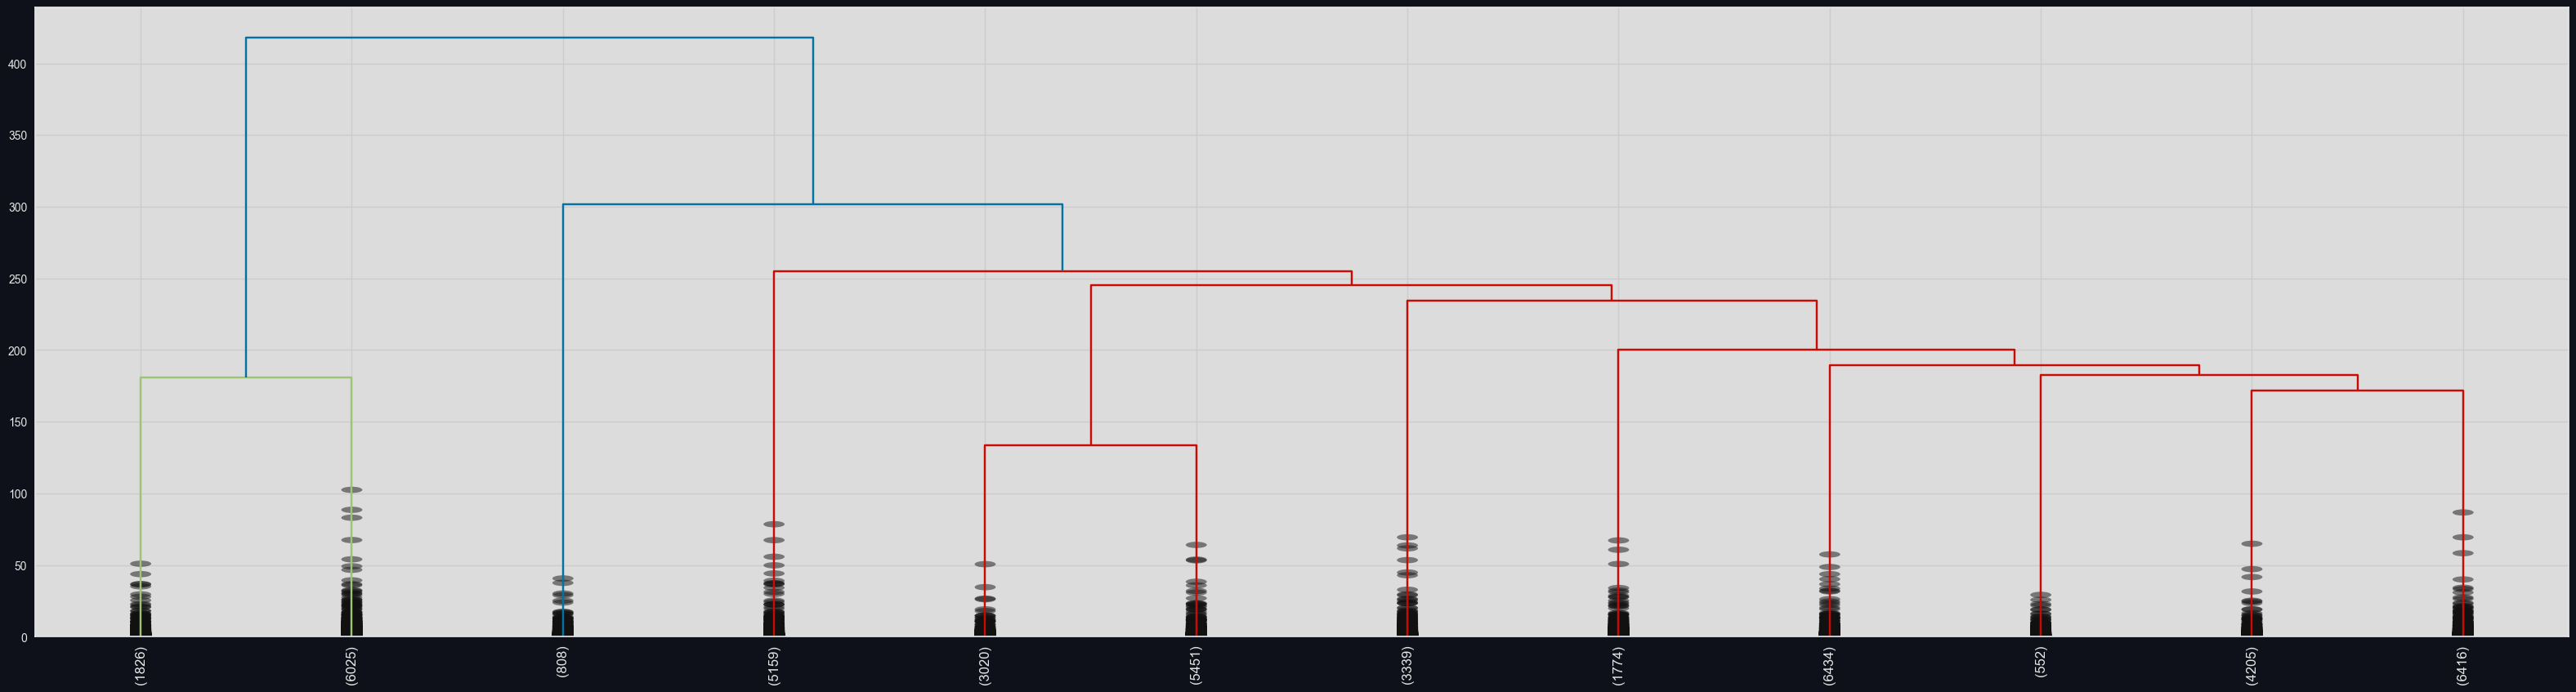

In [6]:
dend, ax = plt.subplots(1, 1, figsize=(40, 10))
dn = dendrogram(
    Z,
    truncate_mode='lastp',  # show only the last p merged clusters
    p=12,  # show only the last p merged clusters
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,  # to get a distribution impression in truncated branches
    ax = ax
)

In [7]:
print('Distance of Last 8 Clusters from linkage array: ')
print(Z[-8:, 2].reshape(8,1))
print('Distance between last 8 Clusters: ')
print(Z[-8:, 2].reshape(8,1) - Z[-9:-1, 2].reshape(8,1))

Distance of Last 8 Clusters from linkage array: 
[[182.55049022]
 [189.4009975 ]
 [200.38413469]
 [234.28269263]
 [245.54730442]
 [254.7714858 ]
 [301.42960094]
 [418.01119422]]
Distance between last 8 Clusters: 
[[  1.80666835]
 [  6.85050727]
 [ 10.98313719]
 [ 33.89855794]
 [ 11.26461179]
 [  9.22418138]
 [ 46.65811514]
 [116.58159328]]


#### **Determining Number of Clusters**

As we can see from above, the point where the distance between clusters is the most obvious is from {301 to 418} (116.58).
We will say that our cut-off is at around 310 for better visualization.

In [8]:
def fancy_dendrogram(*args, **kwargs):
    max_d = kwargs.pop('max_d', None)
    if max_d and 'color_threshold' not in kwargs:
        kwargs['color_threshold'] = max_d
    annotate_above = kwargs.pop('annotate_above', 0)

    ddata = dendrogram(*args, **kwargs)

    if not kwargs.get('no_plot', False):
        plt.title('Hierarchical Clustering Dendrogram (truncated)')
        plt.xlabel('sample index or (cluster size)')
        plt.ylabel('distance')
        for i, d, c in zip(ddata['icoord'], ddata['dcoord'], ddata['color_list']):
            x = 0.5 * sum(i[1:3])
            y = d[1]
            if y > annotate_above:
                plt.plot(x, y, 'o', c=c)
                plt.annotate("%.3g" % y, (x, y), xytext=(0, -5),
                             textcoords='offset points',
                             va='top', ha='center')
        if max_d:
            plt.axhline(y=max_d, c='k')
    return ddata

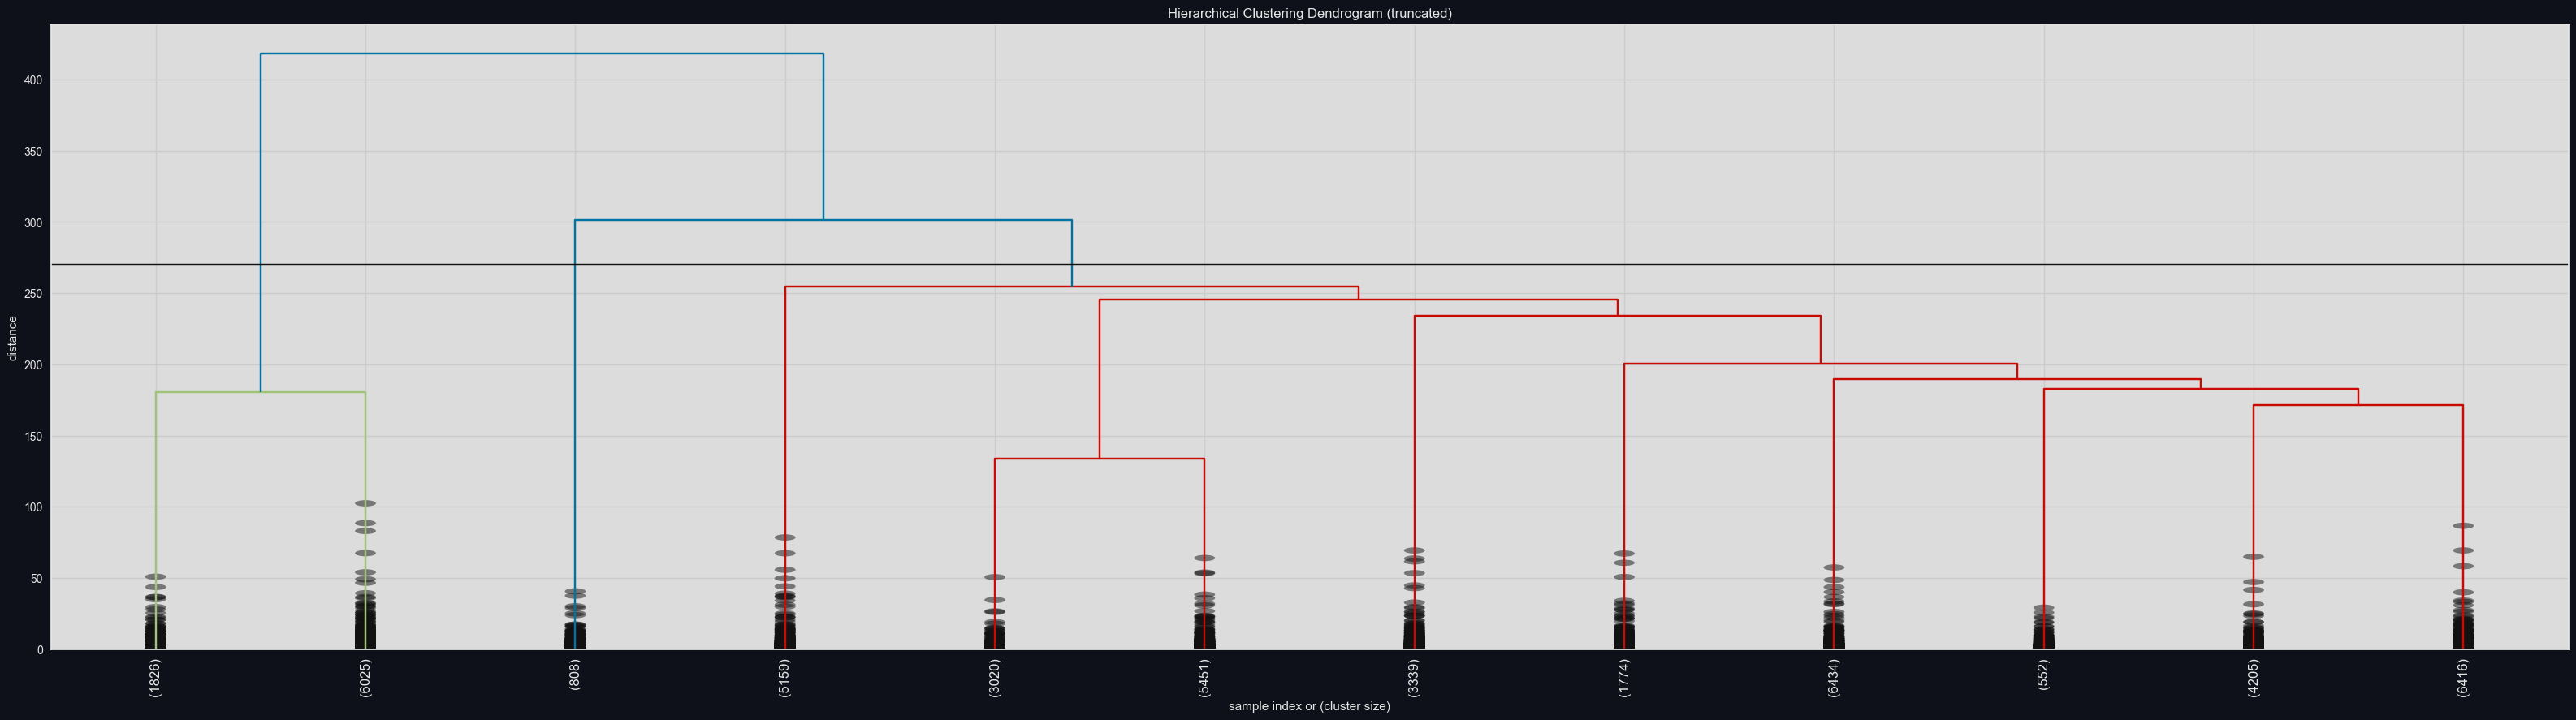

In [22]:
fdend, ax = plt.subplots(1, 1, figsize=(40, 10))
max_d = 270
fdn = fancy_dendrogram(
    Z,
    truncate_mode='lastp',
    p=12,
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,
    annotate_above=1000,  # useful in small plots so annotations don't overlap
    max_d=max_d,
    ax=ax
    )

As we can see from the dendrogram, there are 2 clusters.

#### **Retrieving Clusters**

Now that we know the cut-off, we will be using the function "fcluster".

In [23]:
max_d = 270
clusters = fcluster(Z, max_d, criterion='distance')
print(f'Clusters: {np.unique(clusters)}')

Clusters: [1 2 3]


In [24]:
dfV['Cluster'] = clusters
dfV.to_csv('dfHierClusters.csv', index=False)
dfV.head()

,age,balance,campaign,pdays,previous,job,marital,education,default,housing,loan,contact,poutcome,y,Cluster
0,58,2143,1,0,0,high-skill-levels,Partnered,tertiary,no,yes,no,unknown,unknown,no,3
1,44,29,1,0,0,middle-skill-levels,Alone,secondary,no,yes,no,unknown,unknown,no,3
2,33,2,1,0,0,high-skill-levels,Partnered,secondary,no,yes,yes,unknown,unknown,no,3
3,47,1506,1,0,0,low-None-skill-levels,Partnered,secondary,no,yes,no,unknown,unknown,no,3
4,33,1,1,0,0,low-None-skill-levels,Alone,secondary,no,no,no,unknown,unknown,no,3


In [25]:
numCol = dfV.select_dtypes(include=np.number).columns.tolist()
cateCol = dfV.select_dtypes(exclude=np.number).columns.tolist()
with open ('checkGroupbyCluster_cate_hier.txt', 'w') as f:
    for col in cateCol:
        f.write(str(dfV[col].groupby(dfV['Cluster']).value_counts())+'\n')
        f.write('='*50 + '\n')

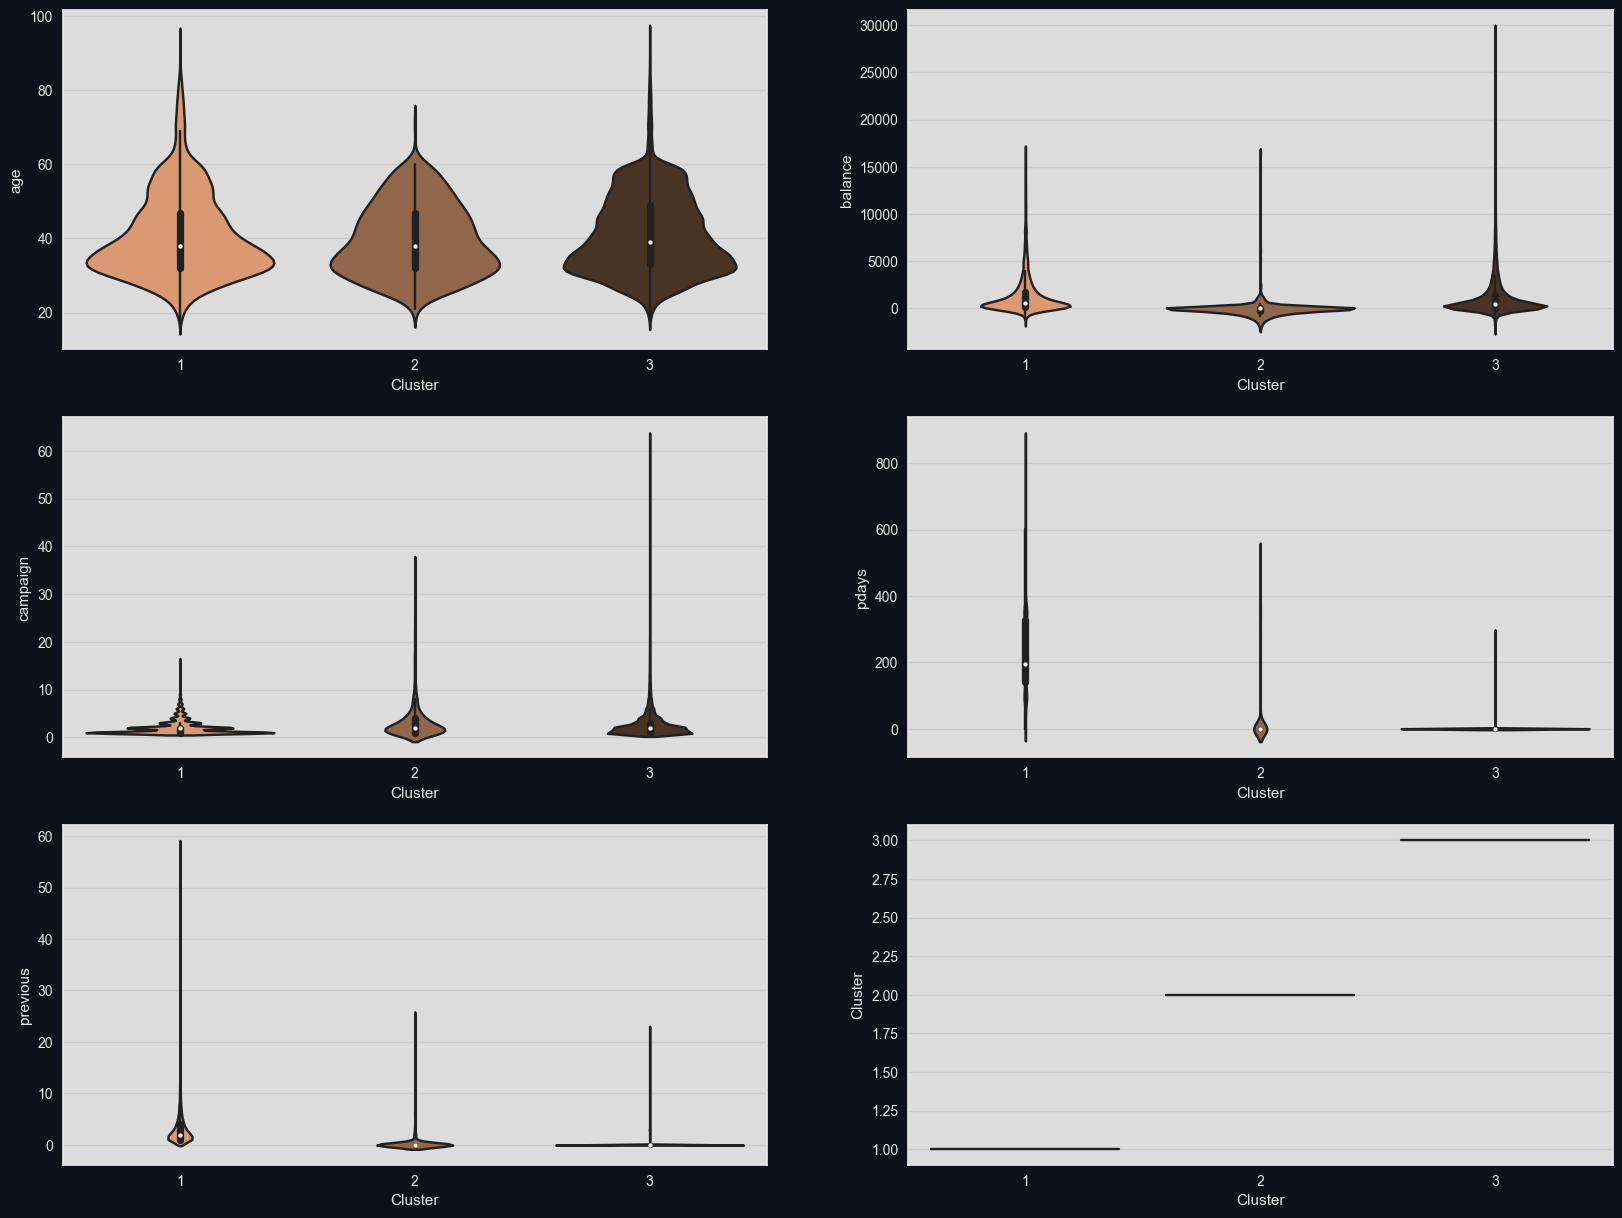

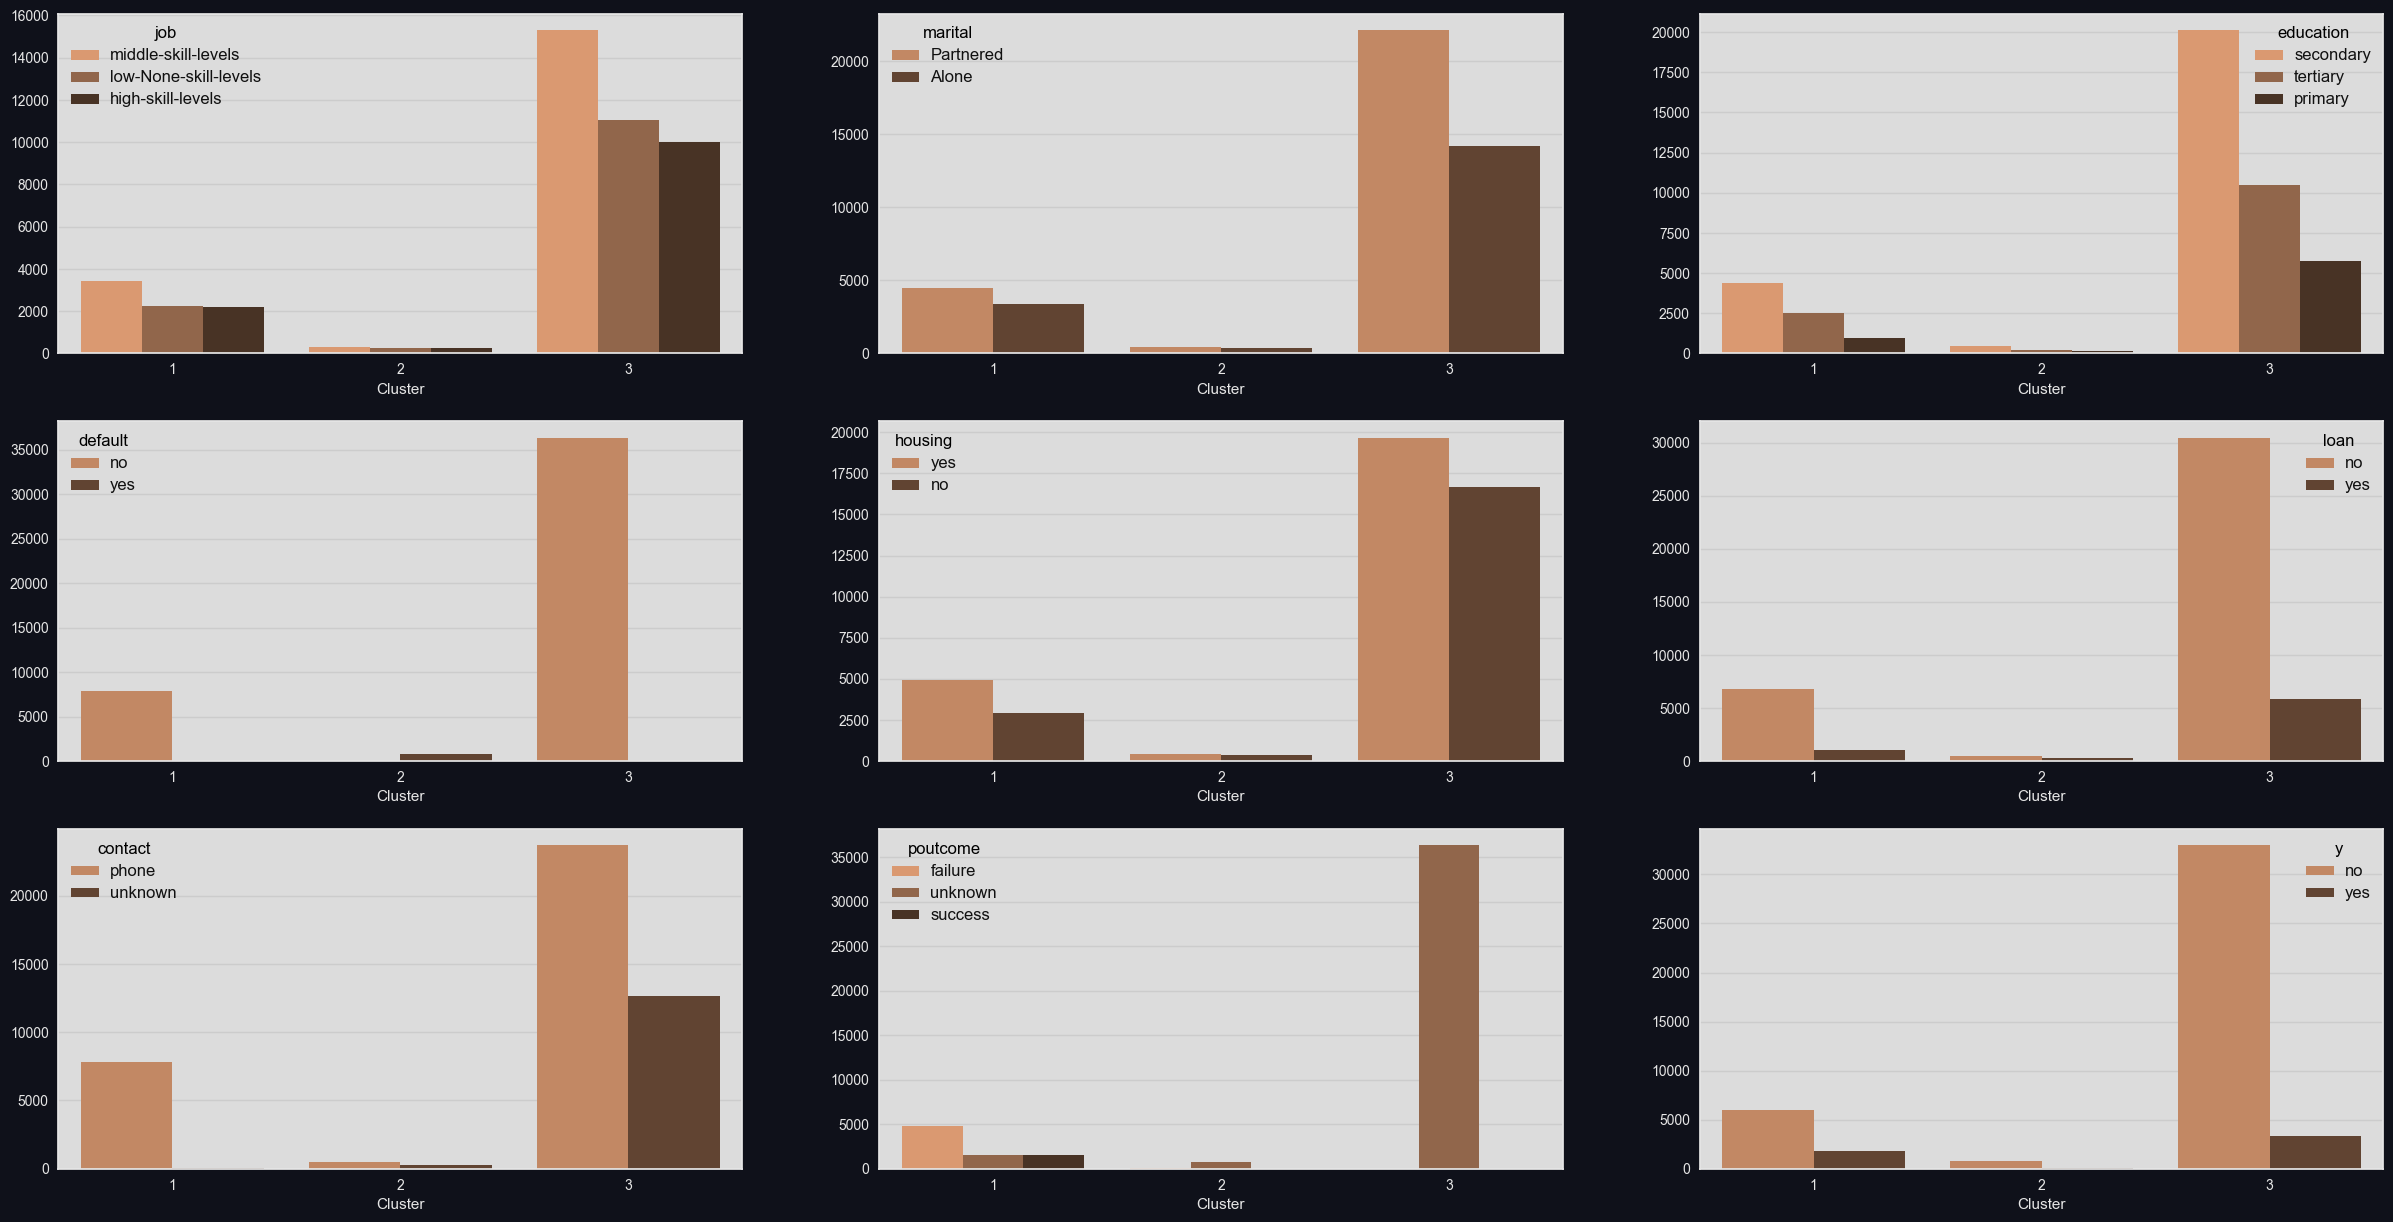

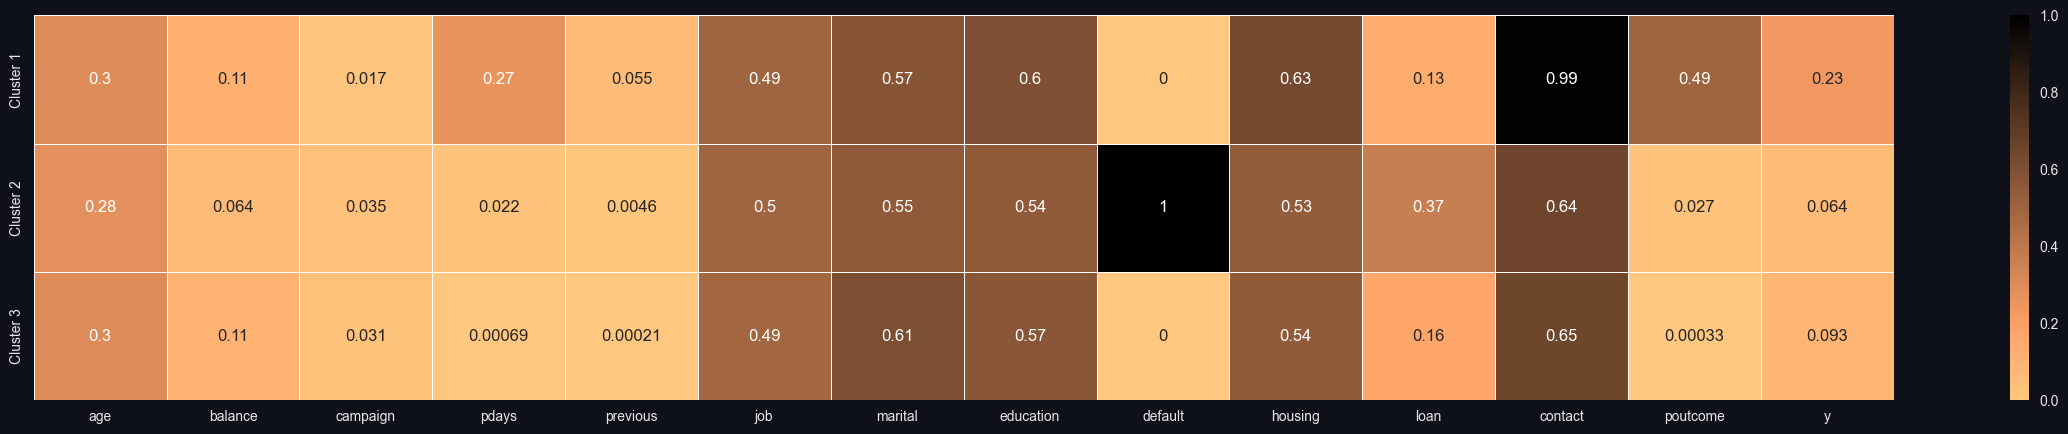

In [26]:
violinFcluster, barFcluster, heatFcluster = clusterVisualization(dfV, numCol, cateCol)

In [ ]:
# figToSave = [dend, fdend, violinFcluster, barFcluster, heatFcluster]
# fileName = ['dendrogram', 'fancy_dendrogram', 'violinFcluster', 'barFcluster', 'heatFcluster']
# for fig in figToSave:
#     fig.savefig(f'img/fcluster/{fileName}.png')

### **Model 4: Hierarchical Clustering** (AgglomerativeClustering)
In model 3, we used fcluster to retrieve clusters. In this model, we will be using AgglomerativeClustering.

We will be using the same number of clusters as model 3.

In [27]:
dfAgglo = pd.read_csv('dfPCAForModeling.csv')
dfV_agglo = pd.read_csv('dfForVisualization_LabelEncode.csv')

In [28]:
n_clusters = 3
agglo = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')
aggloCluster = agglo.fit(dfAgglo)

In [29]:
dfV_agglo['Cluster'] = agglo.labels_ + 1
dfV_agglo.to_csv('dfAggloClusters.csv', index=False)
dfV_agglo.head()

,age,balance,campaign,pdays,previous,job,marital,education,default,housing,loan,contact,poutcome,y,Cluster
0,58,2143,1,0,0,2,1,2,0,1,0,0,0,0,1
1,44,29,1,0,0,1,0,1,0,1,0,0,0,0,1
2,33,2,1,0,0,2,1,1,0,1,1,0,0,0,1
3,47,1506,1,0,0,0,1,1,0,1,0,0,0,0,1
4,33,1,1,0,0,0,0,1,0,0,0,0,0,0,1


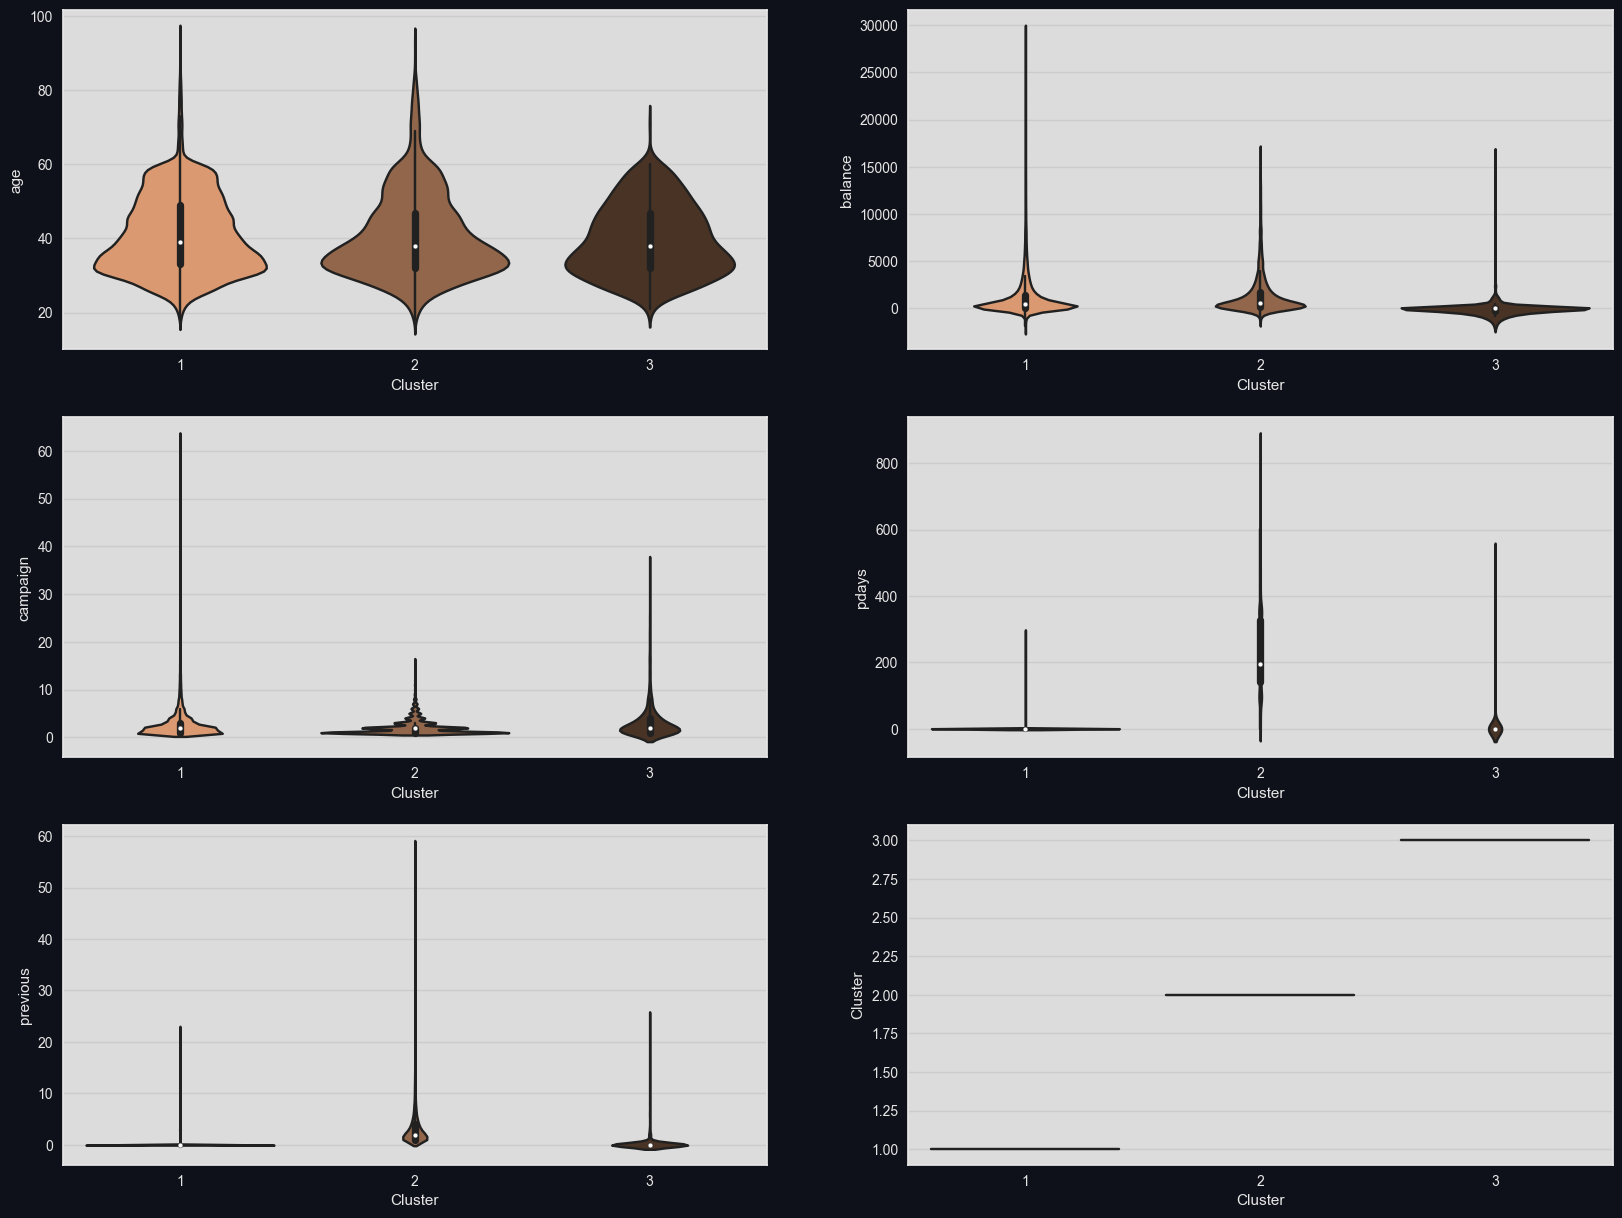

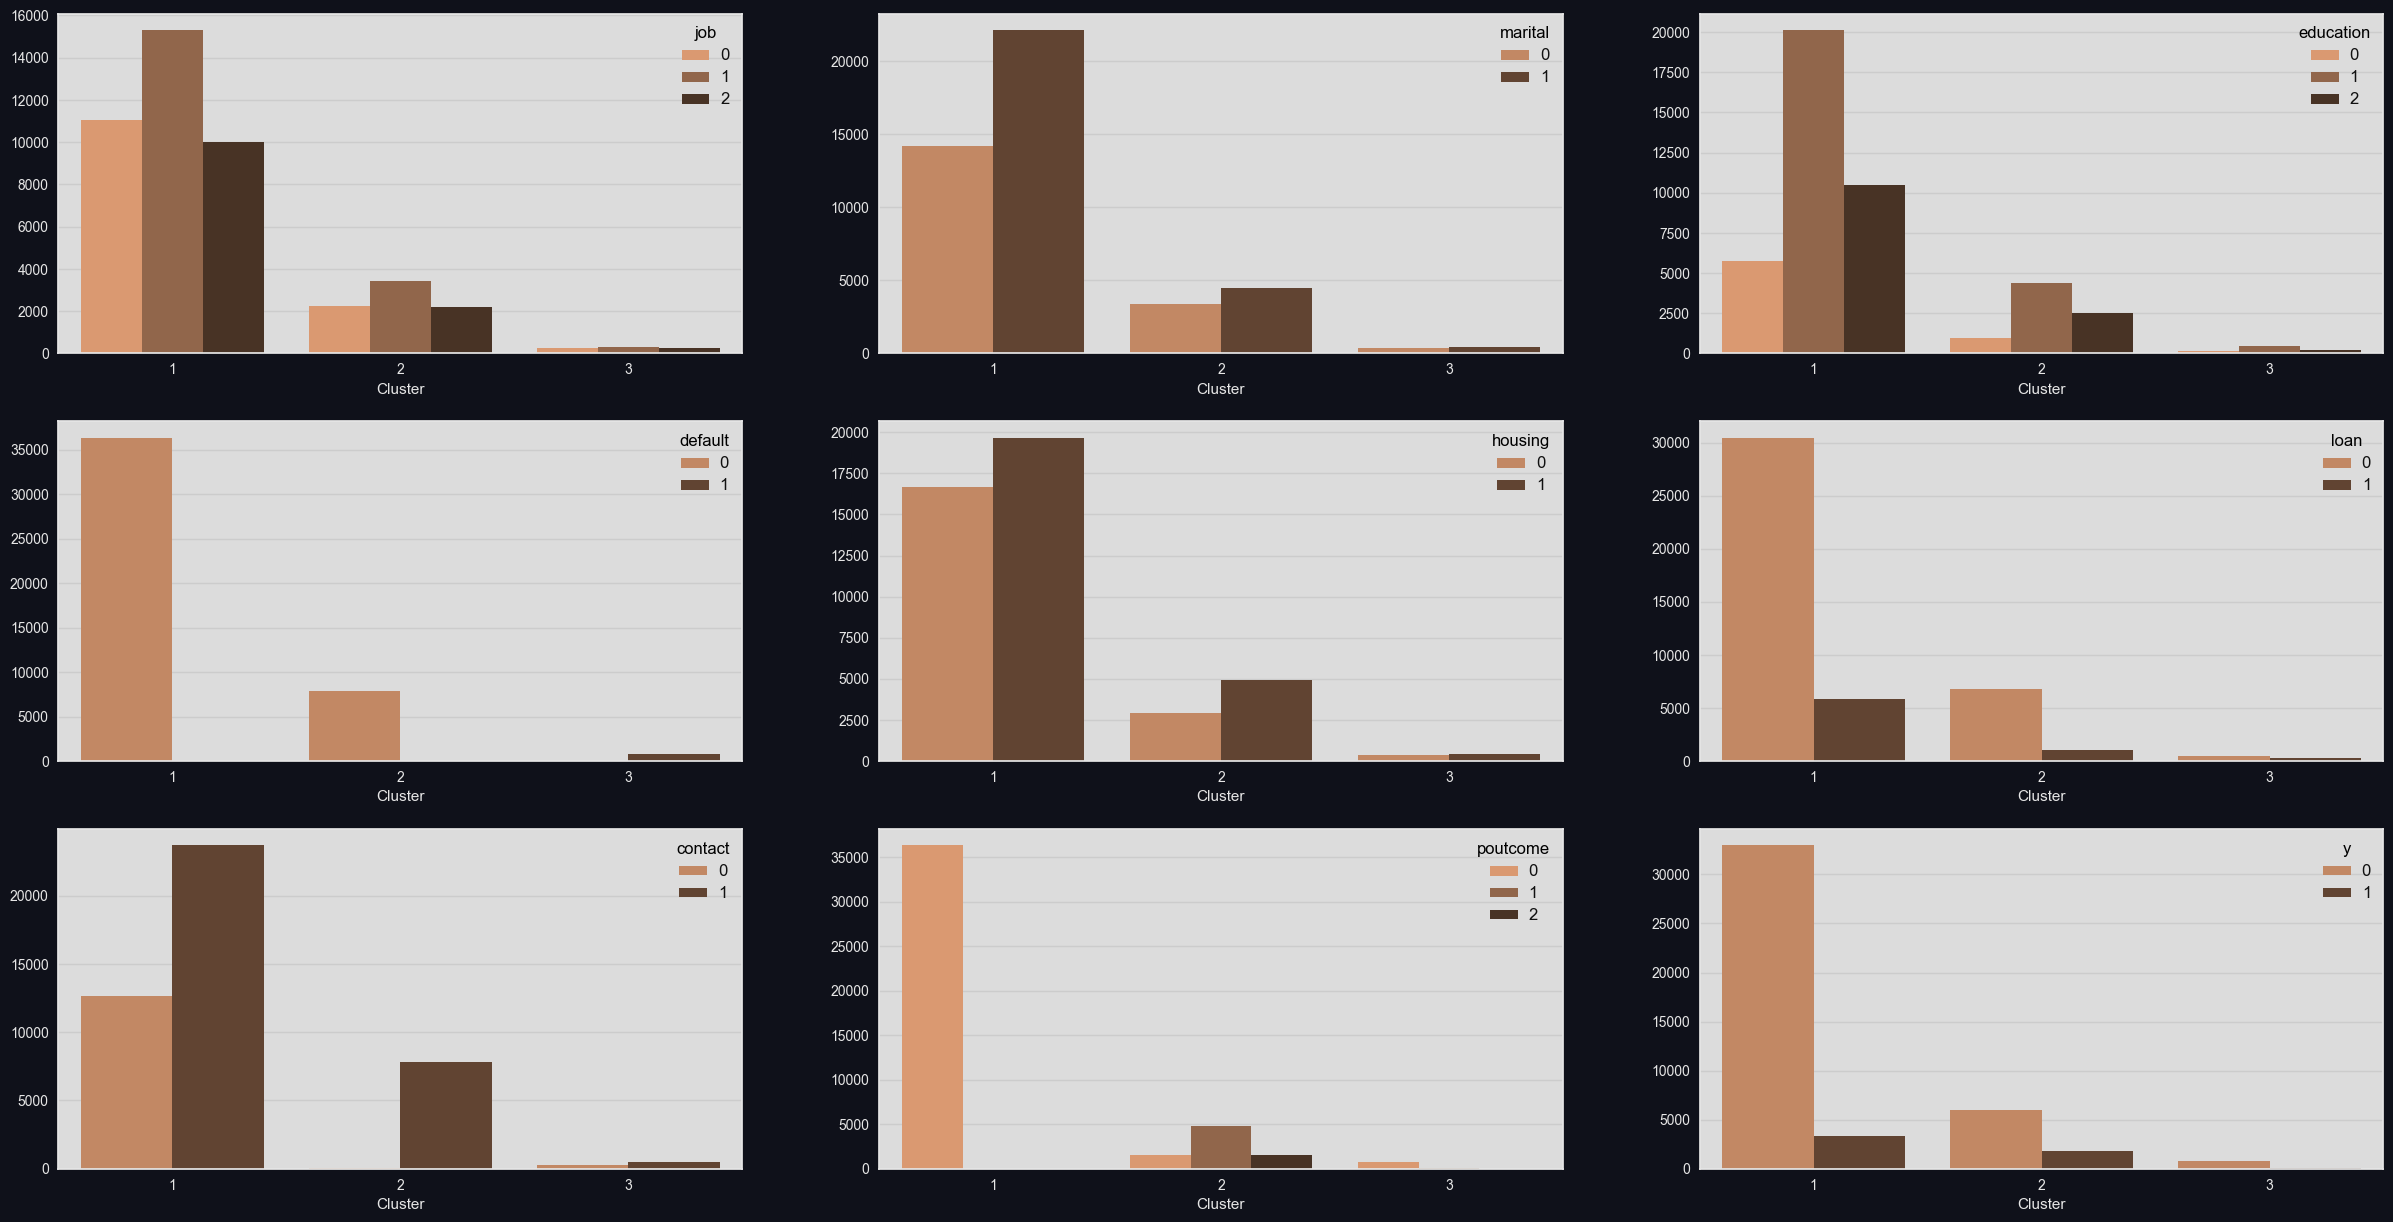

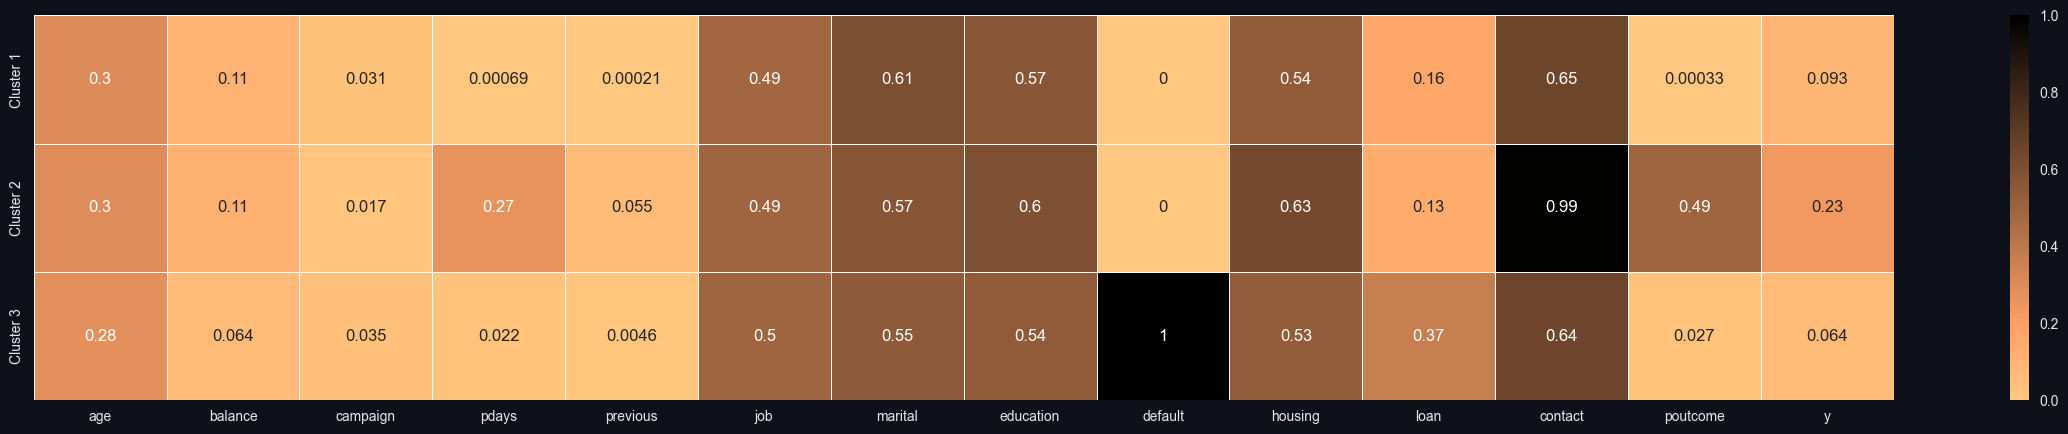

In [30]:
violinAgglo, barAgglo, heatAgglo = clusterVisualization(dfV_agglo, numCol, cateCol)

In [19]:
# figToSave = [violinAgglo, barAgglo, heatAgglo]
# fileName = ['violinAgglo', 'barAgglo', 'heatAgglo']
# for fig in figToSave:
#     fig.savefig(f'img/agglo/{fileName}.png')

### **Model 5: Density-Based Spatial Clustering of Applications with Noise (DBSCAN)**

In [108]:
dfDBSCAN1 = pd.read_csv('dfPCAForModeling.csv')
dfV_DBSCAN = pd.read_csv('dfForVisualization_LabelEncode.csv')
dfDBSCAN1.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10
0,-0.831013,-0.715211,0.473855,-0.451432,2.010056,-1.429894,0.812182,-0.917538,0.637819,1.021139
1,-1.037919,0.066278,-1.204369,-1.072180,-0.184028,-0.385245,0.280836,-0.461026,0.044368,1.210107
2,-1.159324,-0.288987,-1.540329,0.992838,1.027885,-1.696987,-0.875639,0.369540,1.134514,0.492628
3,-1.280680,1.486876,-0.295608,-0.949915,0.633436,-0.714935,0.474173,-0.381035,0.365036,0.285144
4,-1.108253,0.248379,-0.692726,-1.055359,-1.487112,0.169921,-0.069351,-0.181868,-0.575535,1.344235


In [109]:
neigh = NearestNeighbors(n_neighbors=10)
nbrs = neigh.fit(dfDBSCAN1)
distances, indices = nbrs.kneighbors(dfDBSCAN1)

In [110]:
distances = np.sort(distances, axis=0)
distances = distances[:,1]

Text(0, 0.5, 'Distance')

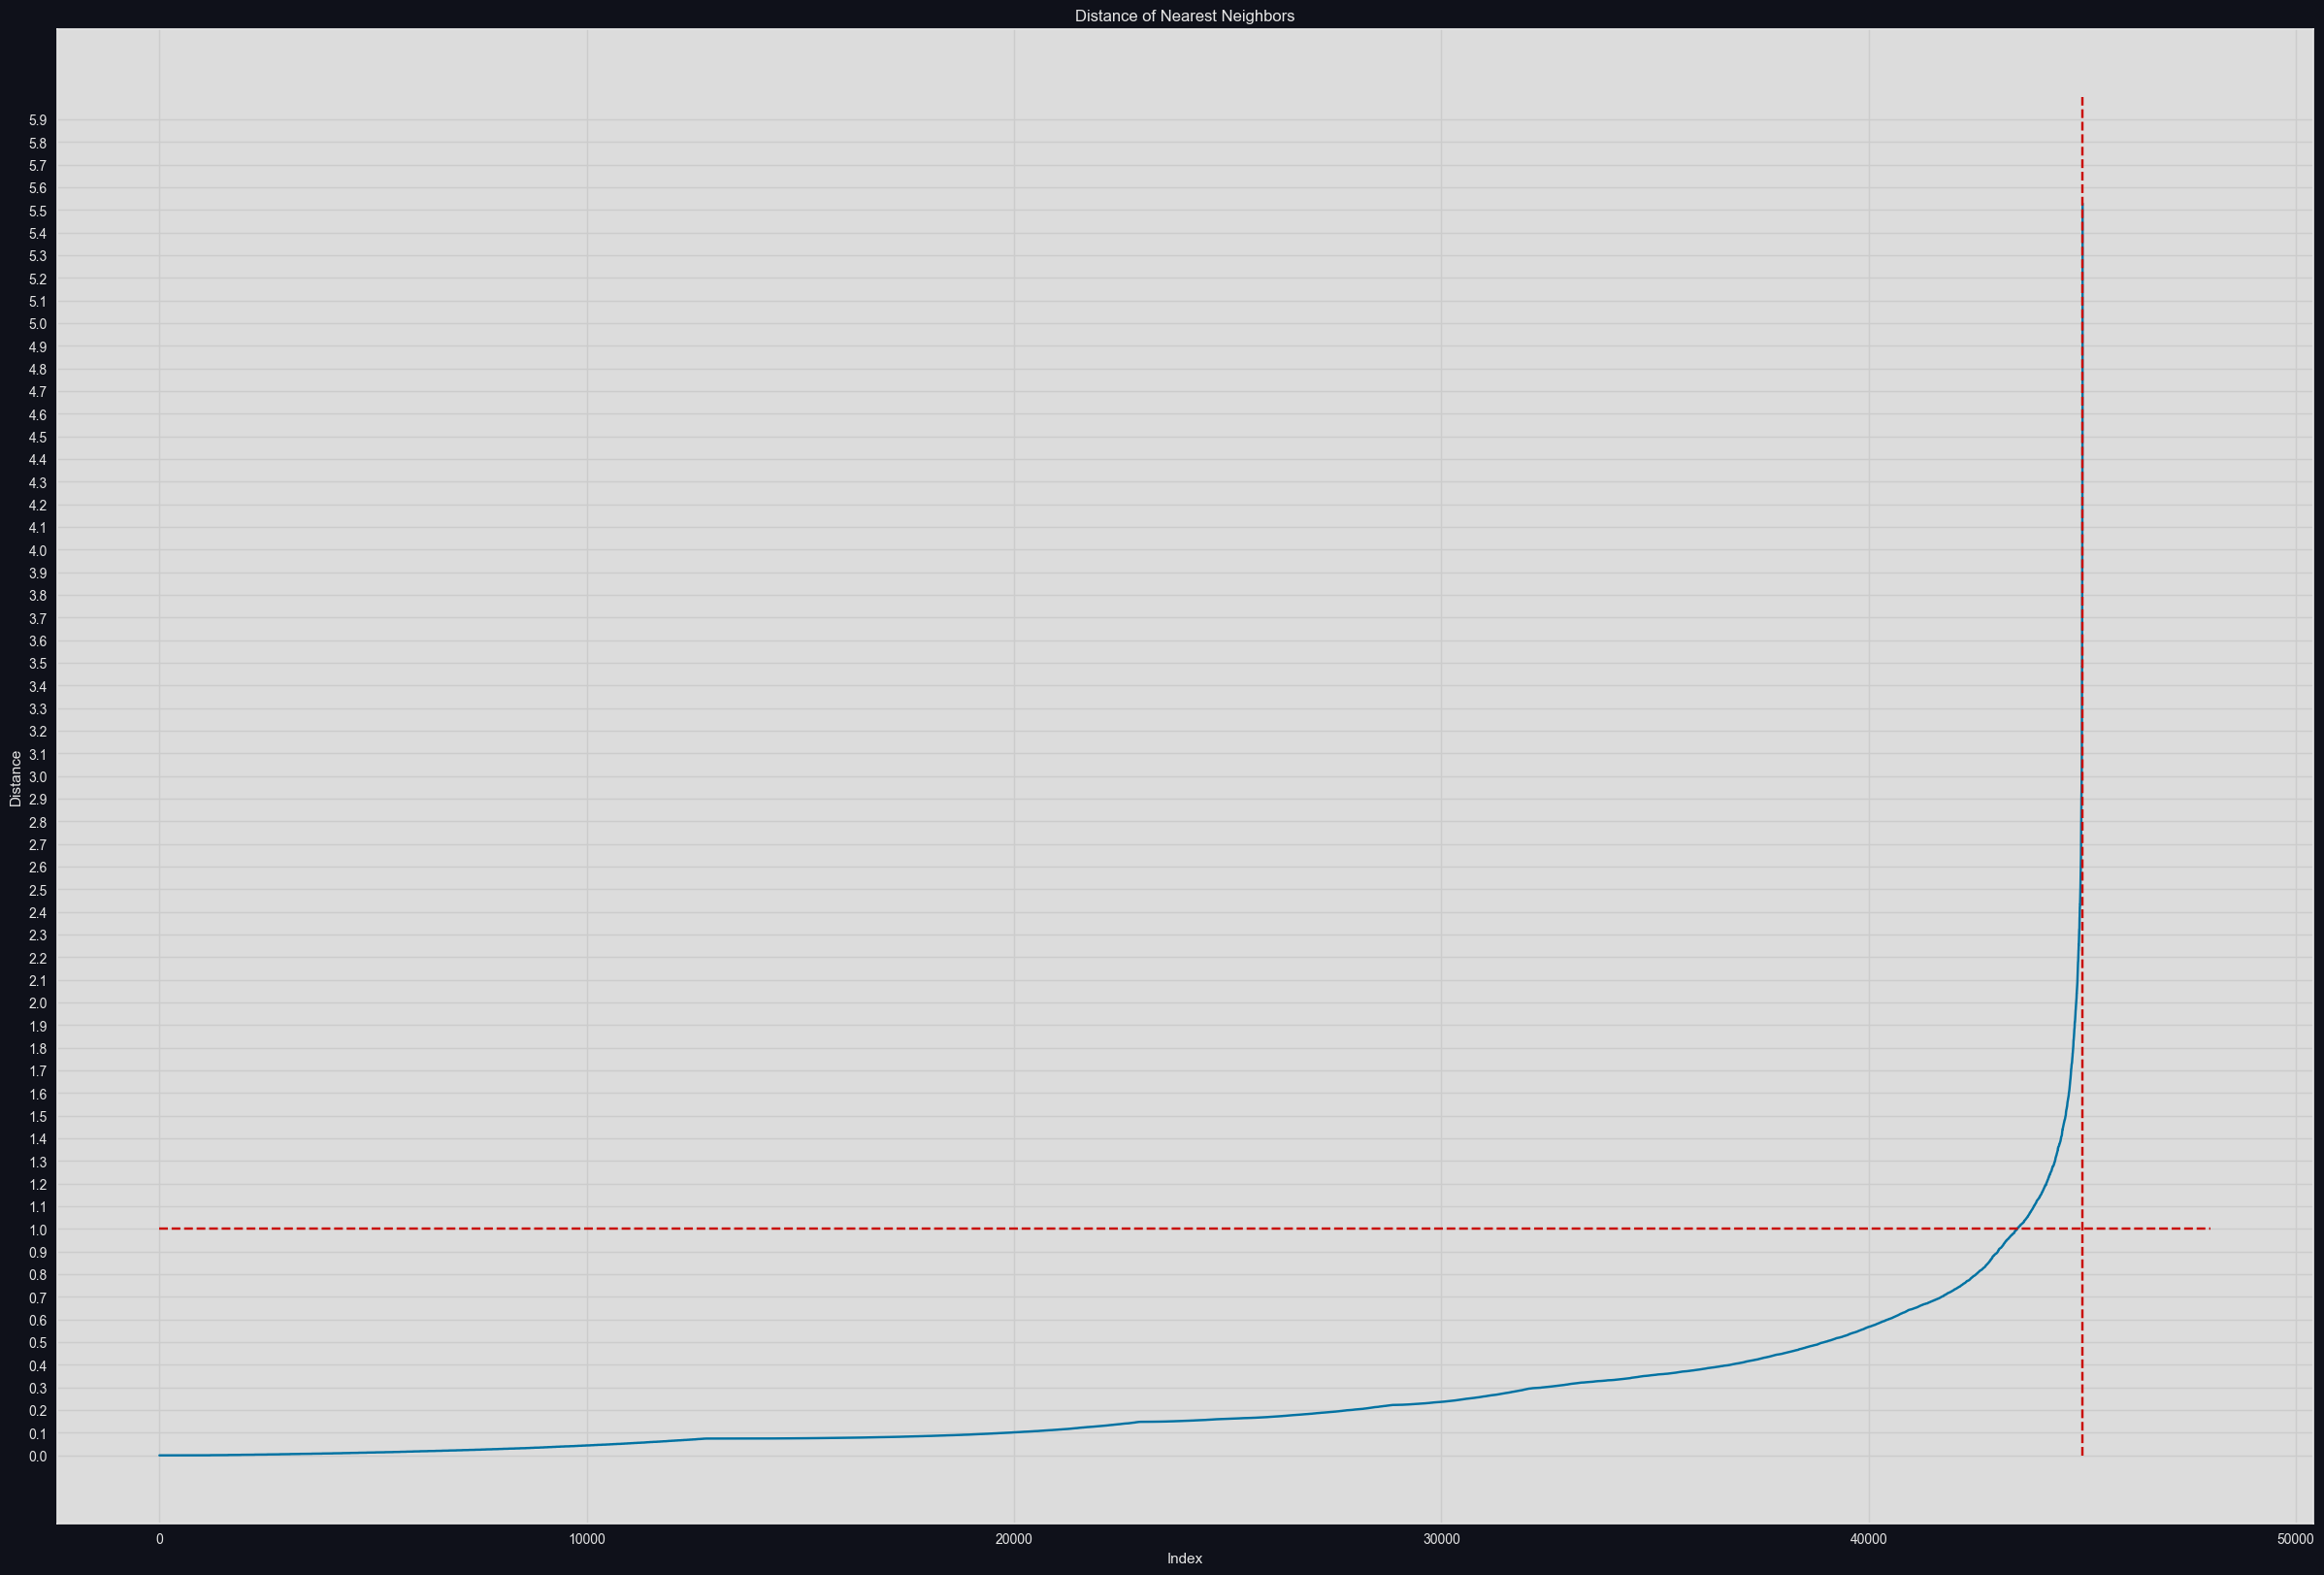

In [111]:
DBSCAN_NN, ax = plt.subplots(1, 1, figsize=(30, 20))
ax.plot(distances)
plt.yticks(np.arange(0, 6, 0.1))
ax.plot([0, 48000], [1, 1], 'r--')
ax.plot([dfDBSCAN1.shape[0], dfDBSCAN1.shape[0]], [0, 6], 'r--')
ax.set_title('Distance of Nearest Neighbors')
ax.set_xlabel('Index')
ax.set_ylabel('Distance')

# plt.plot(distances)


# plt.show()

According to various sources on the internet, the best epsilon is at the knee of the curve. In this case, we will choose 1 as our epsilon.  
Furthermore, we will be using 11 as our minimum samples because we have 10 features and according to https://stats.stackexchange.com/questions/88872/a-routine-to-choose-eps-and-minpts-for-dbscan, we should use number of features + 1.

In [112]:
db1 = DBSCAN(eps=1, min_samples=11).fit(dfDBSCAN1)
clusters = db1.labels_

In [113]:
dfV_DBSCAN['Cluster'] = clusters
dfV_DBSCAN.to_csv('dfDBSCANClusters.csv', index=False)
dfV_DBSCAN.head()

,age,balance,campaign,pdays,previous,job,marital,education,default,housing,loan,contact,poutcome,y,Cluster
0,58,2143,1,0,0,2,1,2,0,1,0,0,0,0,0
1,44,29,1,0,0,1,0,1,0,1,0,0,0,0,1
2,33,2,1,0,0,2,1,1,0,1,1,0,0,0,2
3,47,1506,1,0,0,0,1,1,0,1,0,0,0,0,0
4,33,1,1,0,0,0,0,1,0,0,0,0,0,0,3


In [115]:
for c in dfV_DBSCAN['Cluster'].unique():
    print('Cluster ', c, 'Size: ', round(dfV_DBSCAN[dfV_DBSCAN['Cluster'] == c].shape[0]/dfV_DBSCAN.shape[0]*100), '%', '(Size: ', dfV_DBSCAN[dfV_DBSCAN['Cluster'] == c].shape[0], ')')
print(f"No. of Clusters: {len(set(clusters))}")

Cluster  0 Size:  10 % (Size:  4308 )
Cluster  1 Size:  6 % (Size:  2789 )
Cluster  2 Size:  2 % (Size:  882 )
Cluster  3 Size:  2 % (Size:  959 )
Cluster  4 Size:  1 % (Size:  437 )
Cluster  -1 Size:  10 % (Size:  4404 )
Cluster  5 Size:  1 % (Size:  256 )
Cluster  6 Size:  4 % (Size:  1785 )
Cluster  7 Size:  0 % (Size:  139 )
Cluster  15 Size:  0 % (Size:  13 )
Cluster  8 Size:  0 % (Size:  103 )
Cluster  14 Size:  0 % (Size:  16 )
Cluster  11 Size:  0 % (Size:  114 )
Cluster  9 Size:  0 % (Size:  47 )
Cluster  12 Size:  0 % (Size:  11 )
Cluster  10 Size:  0 % (Size:  31 )
Cluster  13 Size:  0 % (Size:  14 )
Cluster  16 Size:  9 % (Size:  4013 )
Cluster  17 Size:  14 % (Size:  6093 )
Cluster  18 Size:  2 % (Size:  1024 )
Cluster  19 Size:  1 % (Size:  482 )
Cluster  20 Size:  1 % (Size:  347 )
Cluster  21 Size:  3 % (Size:  1210 )
Cluster  22 Size:  2 % (Size:  692 )
Cluster  23 Size:  1 % (Size:  340 )
Cluster  24 Size:  2 % (Size:  835 )
Cluster  25 Size:  14 % (Size:  6464 )
Clus

As you can see, there are a total of 59 clusters including noise cluster.

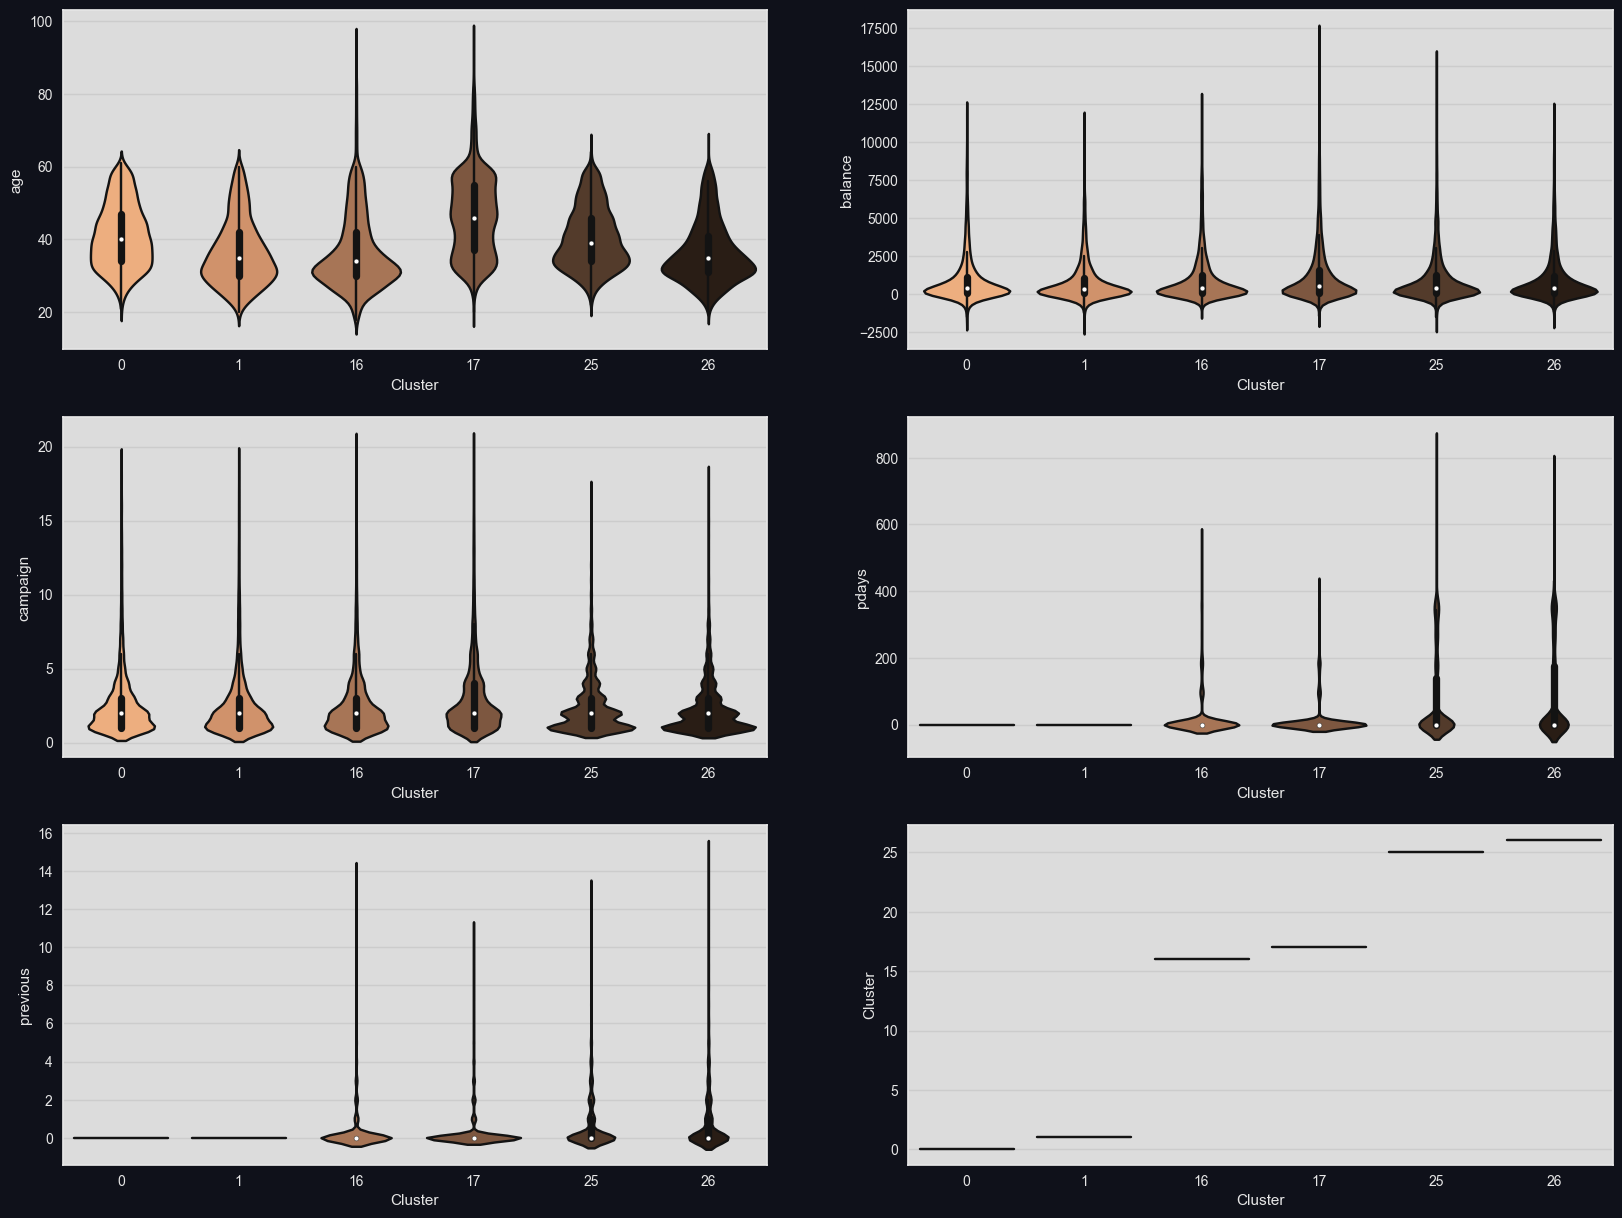

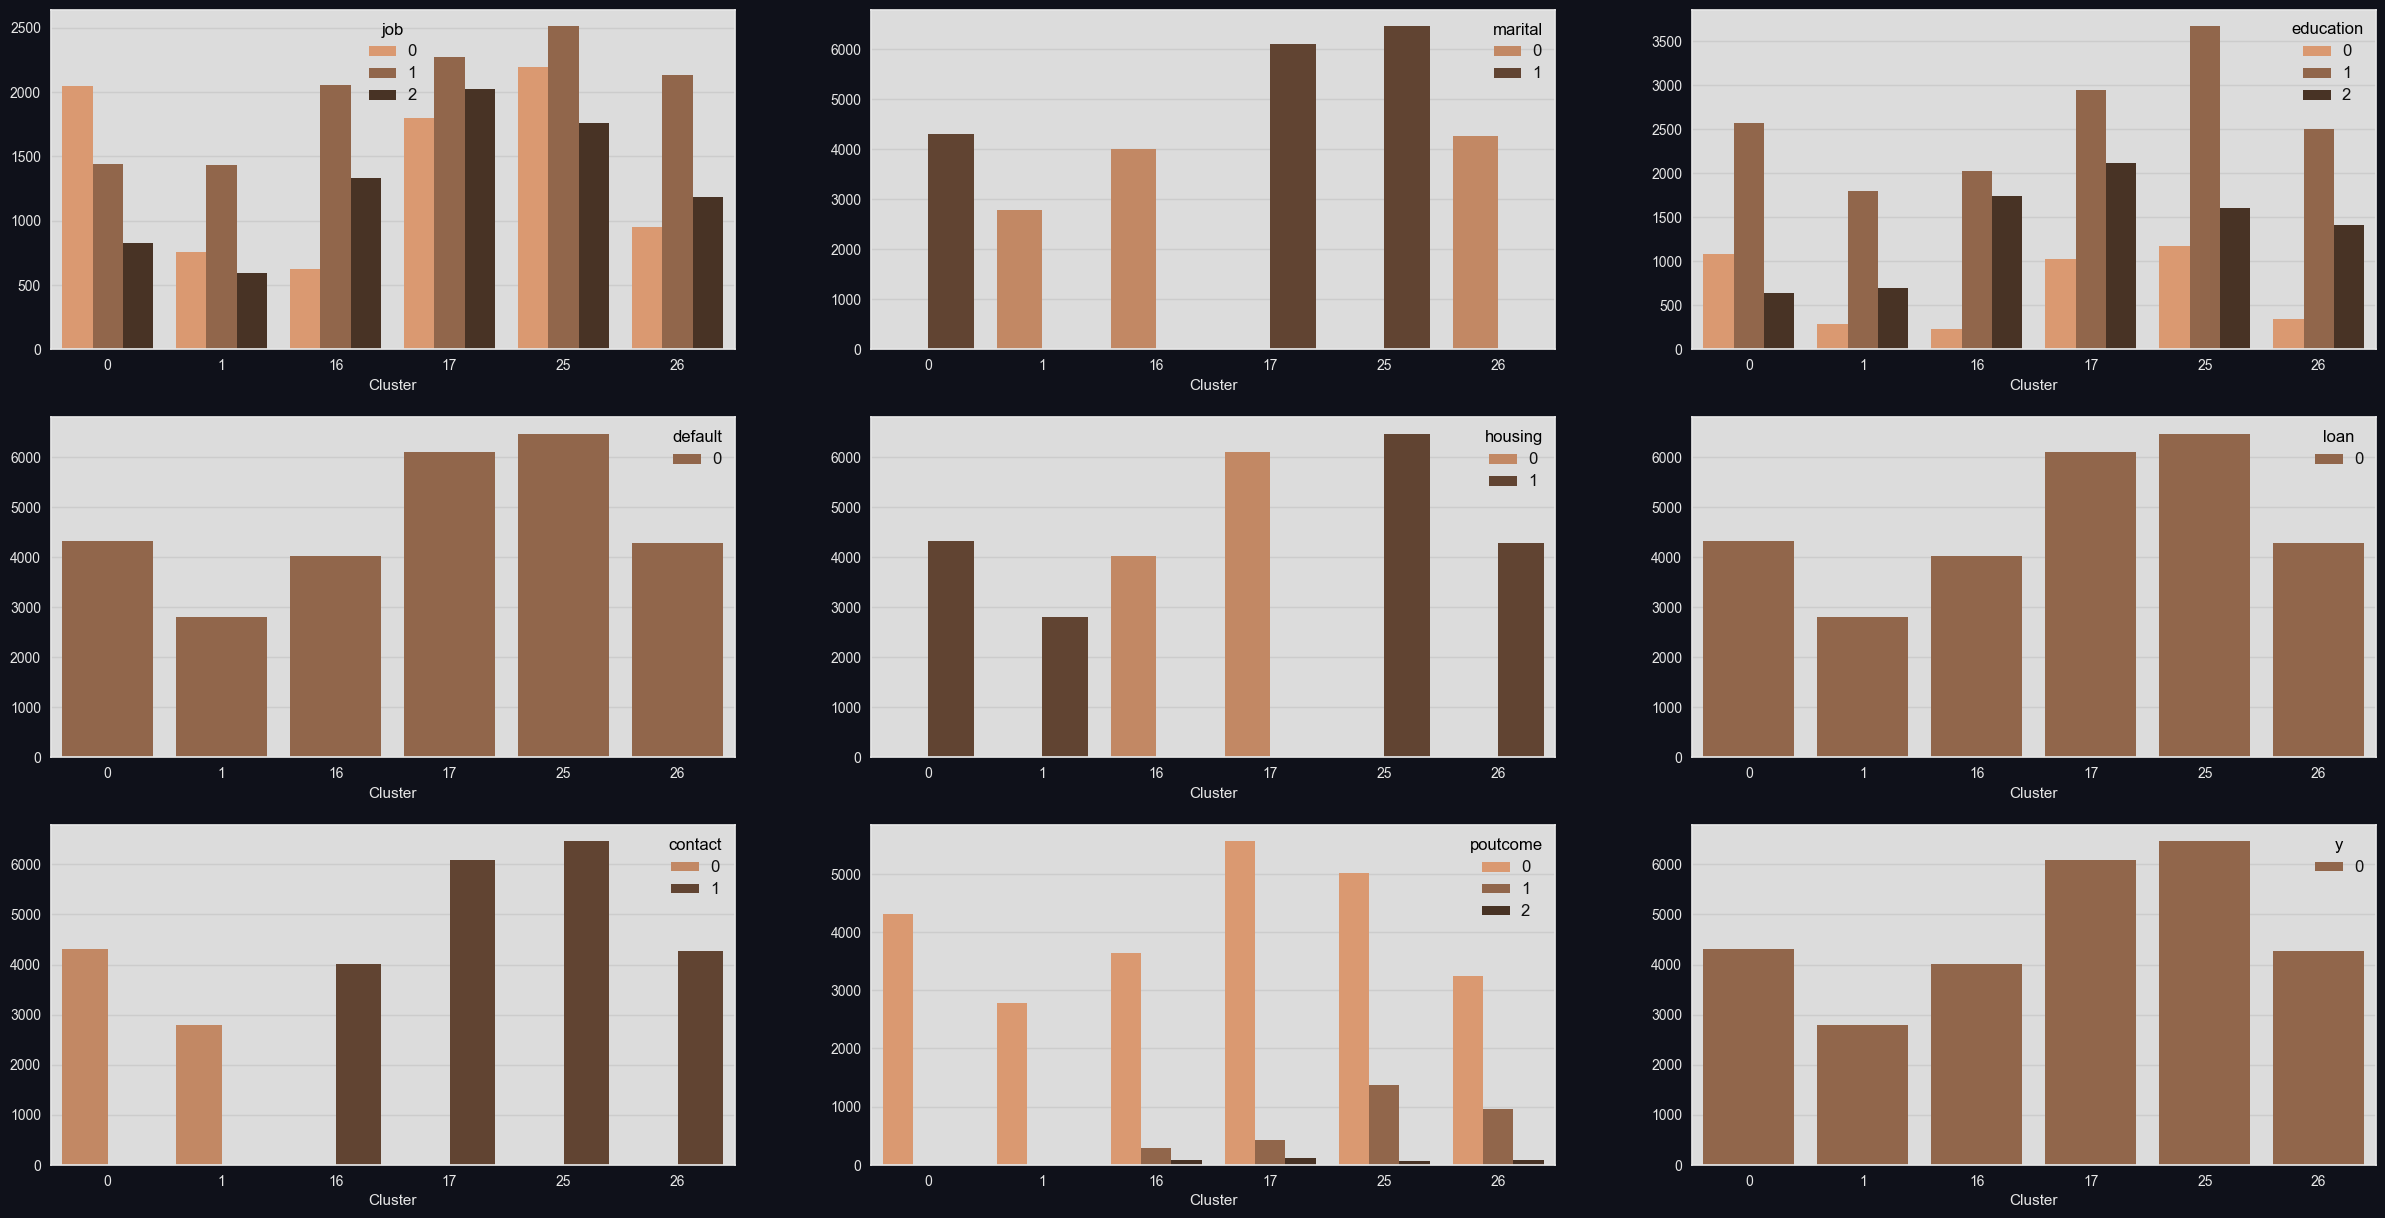

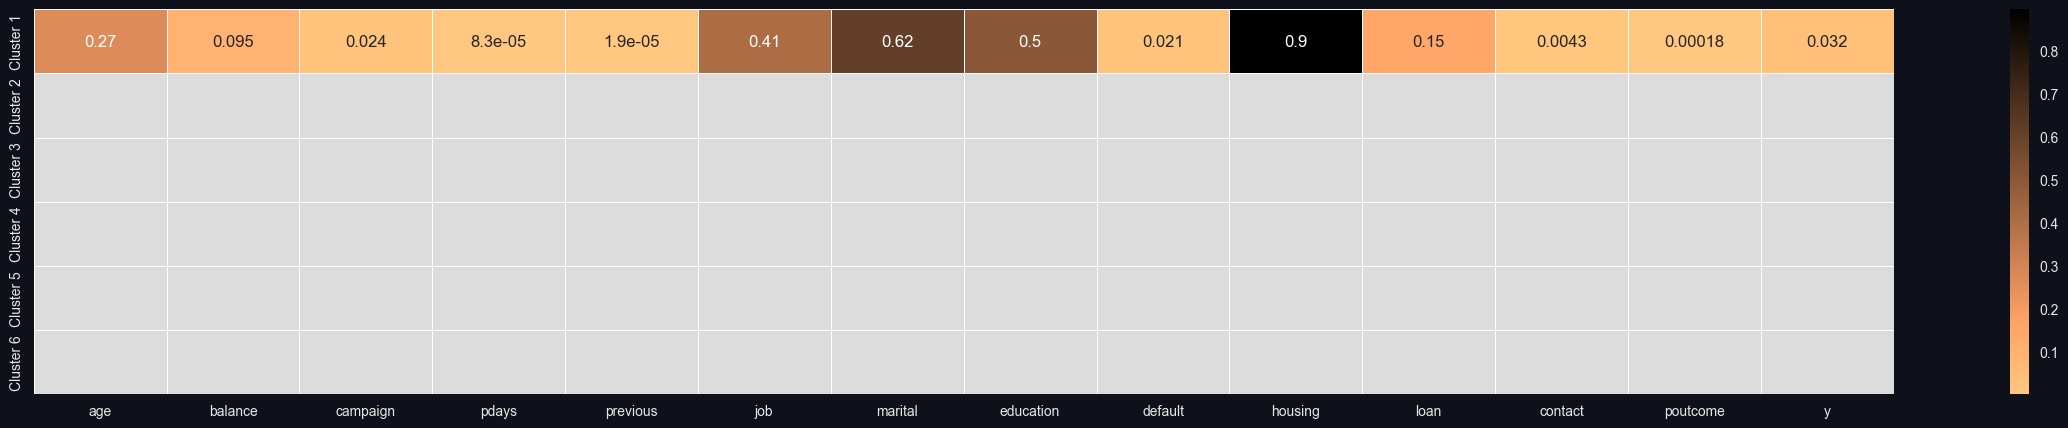

In [107]:
violinDBSCAN, barDBSCAN, heatDBSCAN = clusterVisualization(dfV_DBSCAN, numCol, cateCol)